In [109]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy.fft as fft

In [110]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')
print(device)
global_counter = 0

cpu


In [111]:
num_frames = 100

num_alphas = 10
alphlowlim = 0.0
alphhighlim = 0.9
num_ds = 50
dlowlim = 0.0
dhighlim = 4.9

In [112]:
alpha_vals = np.linspace(alphlowlim, alphhighlim, num_alphas)
print(alpha_vals)
alpha_vals[0] = 1e-10 # set alpha=0 to a small value

d_vals = np.linspace(dlowlim, dhighlim, num_ds)
print(d_vals)
d_vals[0] = 1e-10 # set d=0 to a small value


r_vals = np.linspace(0.0, 10.0, 501)
r_vals = r_vals[:-1]
r_vals[0] = 1e-10 # set r=0 to a small value

# k_vals = fft.fftfreq(r_vals.shape[0], d=r_vals[1]-r_vals[0])
# k_vals = fft.fftshift(k_vals)
dk = 1/(r_vals[-1]-r_vals[0])
# we need only the positive k values
k_vals = np.linspace(0.0, np.pi*dk, (r_vals.shape[0]))
# k_vals = np.linspace(-np.pi*dk, np.pi*dk, (r_vals.shape[0]))
# k_vals = np.linspace(-np.pi/dk, np.pi/dk, r_vals.shape[0])
# print(k_vals)
print(k_vals.shape)

# convert to tensor
r_vals = torch.from_numpy(r_vals).float().to(device)


# print the shape of the data
print(f"shape of alpha_vals : {alpha_vals.shape}")
print(f"shape of d_vals : {d_vals.shape}")

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7
 1.8 1.9 2.  2.1 2.2 2.3 2.4 2.5 2.6 2.7 2.8 2.9 3.  3.1 3.2 3.3 3.4 3.5
 3.6 3.7 3.8 3.9 4.  4.1 4.2 4.3 4.4 4.5 4.6 4.7 4.8 4.9]
(500,)
shape of alpha_vals : (10,)
shape of d_vals : (50,)


In [113]:
# initial guess for P_alpha_d
P_alpha_d = np.zeros((num_frames, num_alphas, num_ds))
# for i in range(num_frames):
#     P_alpha_d[i, 0, 0] = 1.0


alpha0 = 0.2
d0 = 2.5
for i in range(num_alphas):
    for j in range(num_ds):
        P_alpha_d[:, i, j] = np.exp(-((alpha_vals[i] - alpha0)**2 + (d_vals[j] - d0)**2) / 0.1)

# # normalize P_alpha_d
P_alpha_d = P_alpha_d / np.trapz(np.trapz(P_alpha_d, x=d_vals, axis=2), x=alpha_vals, axis=1)[:, None, None]
# P_alpha_d = P_alpha_d / np.sum(P_alpha_d, axis=(1, 2))[:, None, None]


# convert to tensor
alpha_vals = torch.from_numpy(alpha_vals).float().to(device)
# convert to tensor
d_vals = torch.from_numpy(d_vals).float().to(device)
# convert to tensor
k_vals = torch.from_numpy(k_vals).float().to(device)

# convert P_alpha_d to torch tensor
P_alpha_d = torch.tensor(P_alpha_d, dtype=torch.float32, device=device, requires_grad=True)
# restrict P_alpha_d to be positive while training
# P_alpha_d = torch.clamp(P_alpha_d, min=0.0)
# print(P_alpha_d)

In [114]:
def contour_plt(P_alpha_d, i=0):
    """
    Visualise P_alpha_d as a countour plot using contourf
    """
    # plot
    # rescale the y axis to be in the range of 0 to 2
    # rescale the x axis to be in the range of 0 to 1000
    # check if P_alpha_d is a torch tensor
    if isinstance(P_alpha_d, torch.Tensor):
        P_alpha_d_copy = P_alpha_d.detach().cpu().numpy()
    else:
        P_alpha_d_copy = P_alpha_d.copy()
    plt.figure(figsize=(4, 4))
    x = np.linspace(dlowlim, dhighlim, num_ds)
    y = np.linspace(alphlowlim, alphhighlim, num_alphas)
    plt.contourf(x, y, P_alpha_d_copy[i], 20, cmap='RdGy')
    plt.xlabel('d')
    plt.ylabel('alpha')
    plt.colorbar()
    plt.show()

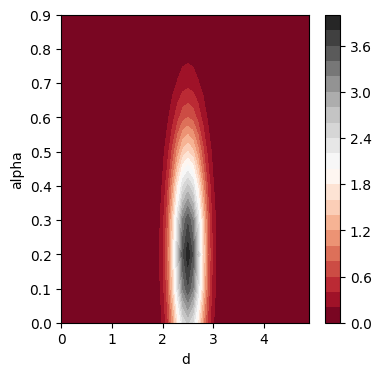

In [115]:
# # visualize P_alpha_d inital in subplots
# for i in range(num_frames):
#     contour_plt(P_alpha_d, i)
contour_plt(P_alpha_d, 50)

In [116]:
# load u_pred
u = np.loadtxt("u.txt")
print(f"shape of u : {u.shape}")
# print(u_pred)
# convert to torch tensor
u = torch.tensor(u, dtype=torch.float32, device=device)
print(f"shape of u : {u.shape}")

shape of u : (100, 500)
shape of u : torch.Size([100, 500])


In [117]:
# load Z
Z = np.load("Z.npy")
print(f"shape of Z : {Z.shape}")
# convert Z to torch tensor
Z = torch.from_numpy(Z).float().to(device)
# print shape of Z
print(f"shape of Z : {Z.shape}")
# print(Z)
# normalize Z to have integral of Z over r equal to 1
# Z = Z / np.sum(Z * (r_vals[1]-r_vals[0]))
# print(Z)

shape of Z : (10, 50, 100, 500)
shape of Z : torch.Size([10, 50, 100, 500])


In [118]:
def give_u_pred(P_alpha_d, Z, alpha_vals, d_vals):
    """
    Given P_alpha_d, Z, alpha_vals, d_vals, return u_pred
    """
    # initialize u_pred
    u_pred = torch.zeros((num_frames, len(r_vals)))
    # move u_pred to device
    u_pred = u_pred.to(device)

    for i in range(u_pred.shape[0]):
        for j in range(u_pred.shape[1]):
            integrand = torch.trapz(P_alpha_d[i] * Z[:, :, i, j], d_vals)
            u_pred[i, j] = torch.trapz(integrand, alpha_vals)

    # normalize u_pred
    # u_pred = u_pred / (u_pred.sum(dim=1, keepdim=True) + 1e-9)
    # u_pred = u_pred / (torch.trapz(u_pred, k_vals, dim=1, keepdim=True))
    norm = torch.trapz(u_pred, k_vals, dim=1)
    u_pred = u_pred / norm[:, None]
    # u_pred = u_pred / np.trapz(u_pred, k_vals, axis=1).reshape(-1, 1)
    
    # norm = (torch.trapz(u_pred, k_vals, dim=1))

    # u_pred = u_pred / norm[:, None]


    return u_pred    

In [119]:
# manual loss function
def loss_function(P_alpha_d, u, Z, alpha_vals, d_vals, global_counter):
    # clamp P_alpha_d to be positive
    # P_alpha_d.data = P_alpha_d.data.clamp(min=0.0)
    # normalize P_alpha_d
    norm = (torch.trapz(torch.trapz(P_alpha_d, d_vals, dim=2), alpha_vals, dim=1))
    P_alpha_d = P_alpha_d / norm[:, None, None]
    # P_alpha_d = P_alpha_d / (torch.trapz(torch.trapz(P_alpha_d, d_vals, dim=2), alpha_vals, dim=1, keepdim=True) + 1e-6)
    # P_alpha_d = P_alpha_d / (P_alpha_d.sum(dim=(1,2), keepdim=True))
    # P_alpha_d = P_alpha_d / (P_alpha_d.sum(dim=(1,2), keepdim=True) + 1e-6)
    # calculate u_pred using double integral
    u_pred = give_u_pred(P_alpha_d, Z, alpha_vals, d_vals)
    # calculate loss
    loss = torch.sum((u_pred - u)**2)
    # loss /= u.shape[0] * u.shape[1]
    # loss = torch.sum(abs(u_pred - u))
    # plot u_pred and u
    if(global_counter%5 == 0):
        plt.plot(u_pred.detach().cpu().numpy()[20], label='u_pred')
        plt.plot(u.detach().cpu().numpy()[20], label='u')
        plt.legend()
        plt.show()

    return loss

In [120]:
# write a function to train the model
def train(P_alpha_d, u, Z, alpha_vals, d_vals, num_epochs=100, lr=1e-1):
    # define the optimizer
    optimizer = torch.optim.Adam([P_alpha_d], lr=lr)
    # define the loss function
    loss_func = loss_function
    # define the loss history
    loss_history = []
    global_counter = 0
    # train the model
    for epoch in range(num_epochs):
        # calculate loss
        loss = loss_func(P_alpha_d, u, Z, alpha_vals, d_vals, global_counter)
        # zero the gradients
        optimizer.zero_grad()
        # backpropagate
        loss.backward()
        # update parameters
        optimizer.step()
        # append loss to loss history
        loss_history.append(loss.item())
        P_alpha_d.data = P_alpha_d.data.clamp(min=0.0)
        global_counter += 1
        # plot P_alpha_d
        if (epoch+1) % 5 == 0:
            contour_plt(P_alpha_d, 50)
        # print loss
        if (epoch+1) % 1 == 0:
            print(f"epoch {epoch+1} / {num_epochs} : loss = {loss.item()}")
    # plot loss history
    plt.figure()
    plt.plot(loss_history)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()

    return P_alpha_d

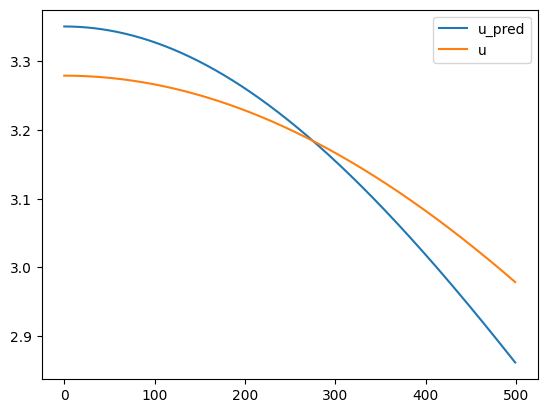

epoch 1 / 500 : loss = 160.25869750976562
epoch 2 / 500 : loss = 146.37606811523438
epoch 3 / 500 : loss = 133.97105407714844
epoch 4 / 500 : loss = 122.85076141357422


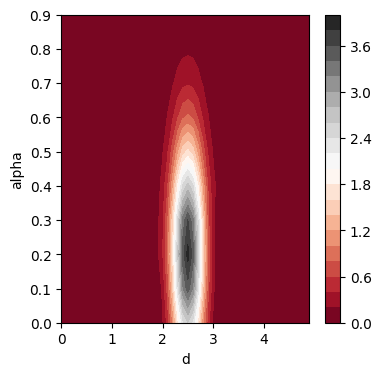

epoch 5 / 500 : loss = 112.87354278564453


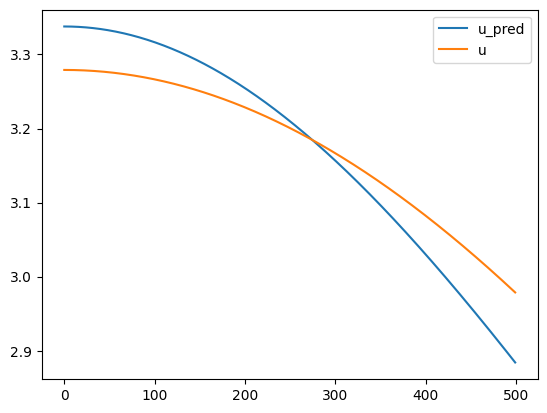

epoch 6 / 500 : loss = 103.8602294921875
epoch 7 / 500 : loss = 95.70600891113281
epoch 8 / 500 : loss = 88.31951904296875
epoch 9 / 500 : loss = 81.64546203613281


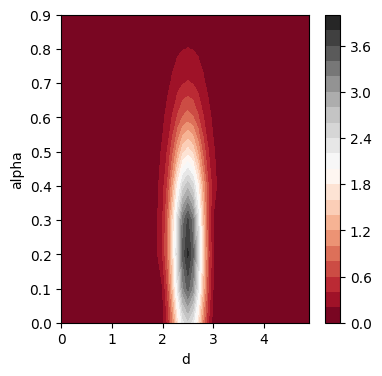

epoch 10 / 500 : loss = 75.58998107910156


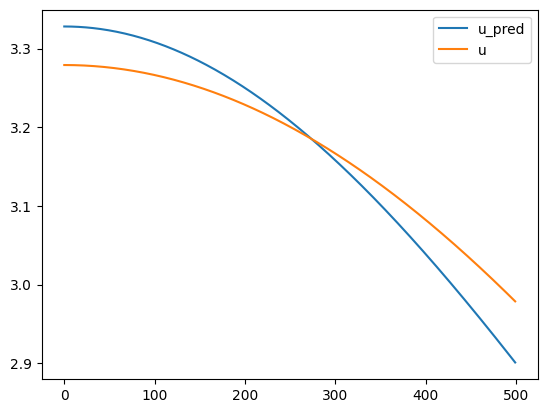

epoch 11 / 500 : loss = 70.08839416503906
epoch 12 / 500 : loss = 65.11297607421875
epoch 13 / 500 : loss = 60.5885124206543
epoch 14 / 500 : loss = 56.45466995239258


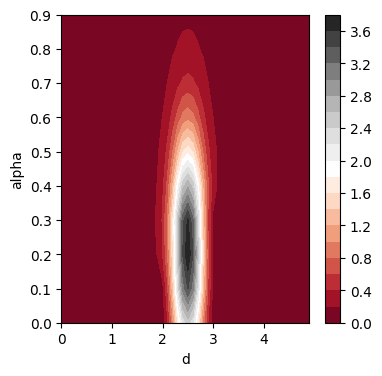

epoch 15 / 500 : loss = 52.67343521118164


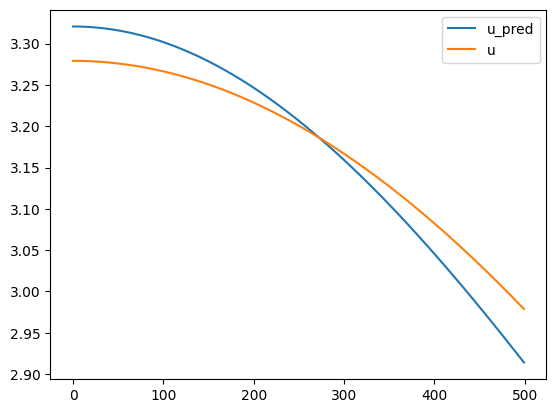

epoch 16 / 500 : loss = 49.20988082885742
epoch 17 / 500 : loss = 46.03114318847656
epoch 18 / 500 : loss = 43.10978317260742
epoch 19 / 500 : loss = 40.42180252075195


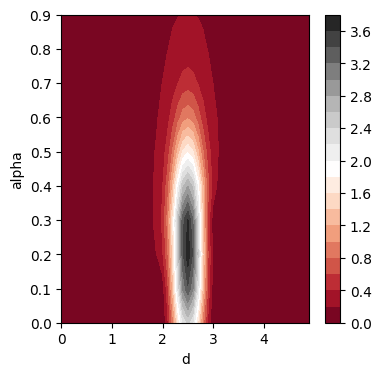

epoch 20 / 500 : loss = 37.944435119628906


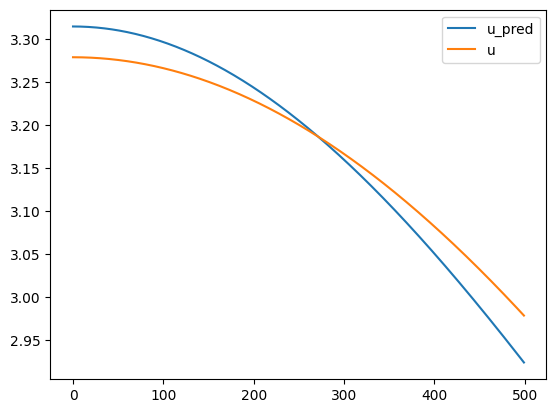

epoch 21 / 500 : loss = 35.65825271606445
epoch 22 / 500 : loss = 33.54555130004883
epoch 23 / 500 : loss = 31.591197967529297
epoch 24 / 500 : loss = 29.781742095947266


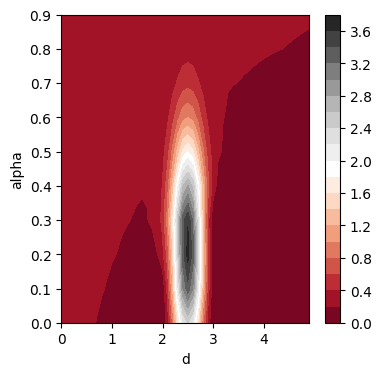

epoch 25 / 500 : loss = 28.108827590942383


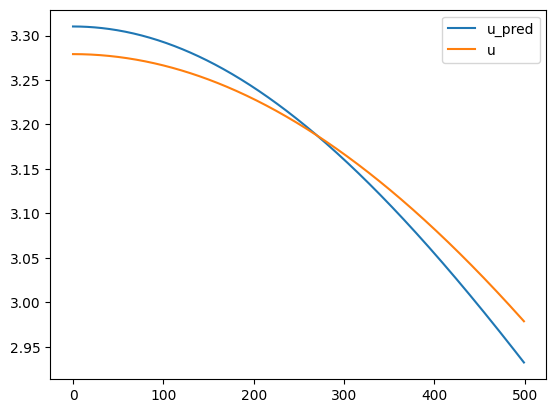

epoch 26 / 500 : loss = 26.560665130615234
epoch 27 / 500 : loss = 25.120826721191406
epoch 28 / 500 : loss = 23.779674530029297
epoch 29 / 500 : loss = 22.528827667236328


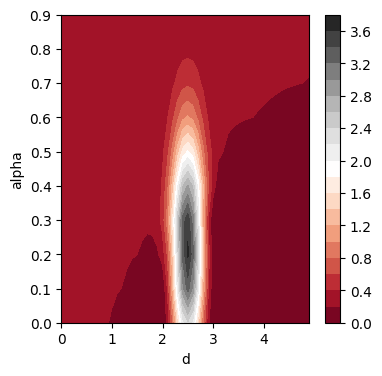

epoch 30 / 500 : loss = 21.36199951171875


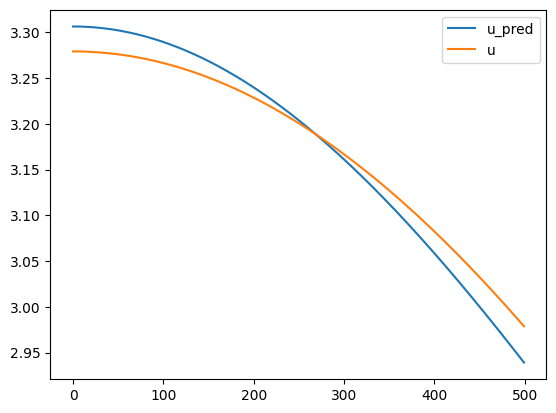

epoch 31 / 500 : loss = 20.274738311767578
epoch 32 / 500 : loss = 19.259889602661133
epoch 33 / 500 : loss = 18.31018829345703
epoch 34 / 500 : loss = 17.419410705566406


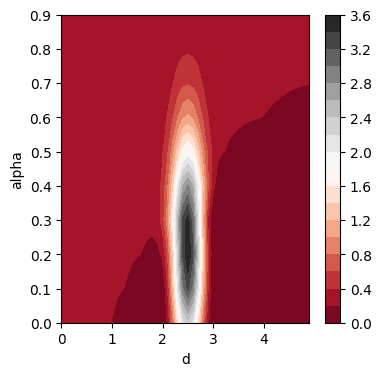

epoch 35 / 500 : loss = 16.58704376220703


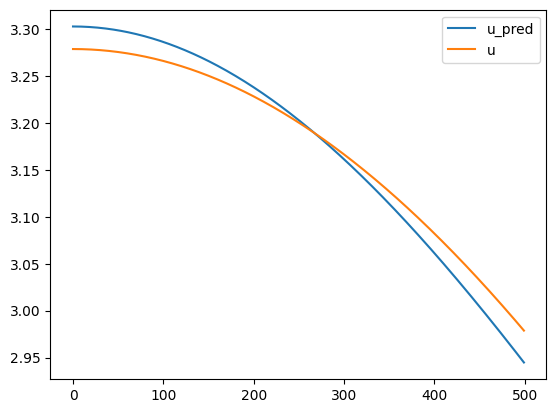

epoch 36 / 500 : loss = 15.807579040527344
epoch 37 / 500 : loss = 15.073968887329102
epoch 38 / 500 : loss = 14.387429237365723
epoch 39 / 500 : loss = 13.73982048034668


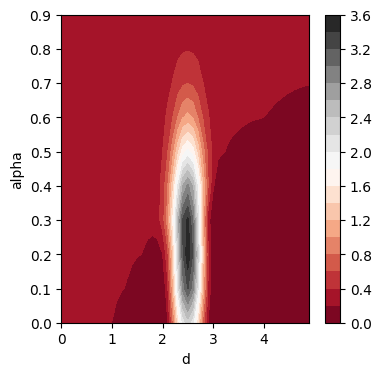

epoch 40 / 500 : loss = 13.127946853637695


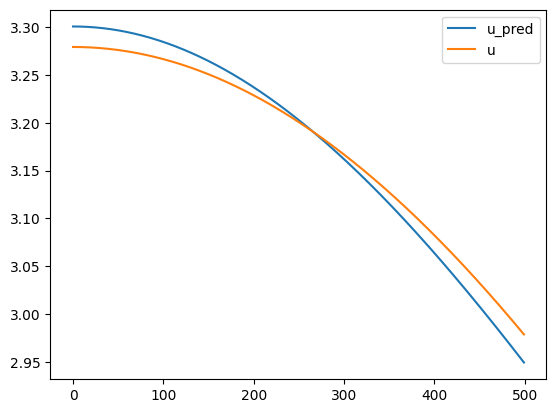

epoch 41 / 500 : loss = 12.549079895019531
epoch 42 / 500 : loss = 12.00090217590332
epoch 43 / 500 : loss = 11.481341361999512
epoch 44 / 500 : loss = 10.988630294799805


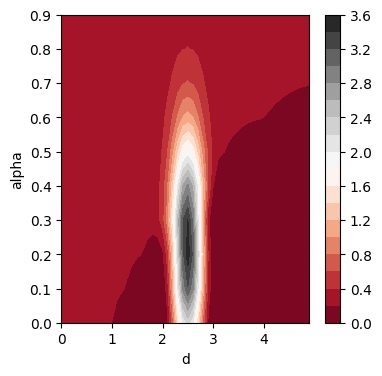

epoch 45 / 500 : loss = 10.521112442016602


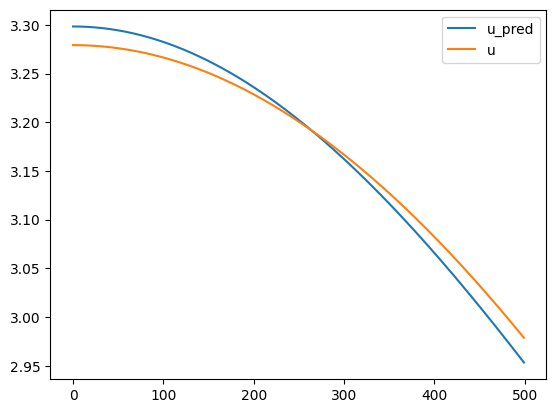

epoch 46 / 500 : loss = 10.077261924743652
epoch 47 / 500 : loss = 9.655645370483398
epoch 48 / 500 : loss = 9.25490665435791
epoch 49 / 500 : loss = 8.873876571655273


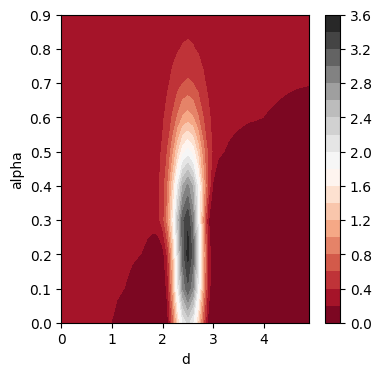

epoch 50 / 500 : loss = 8.511433601379395


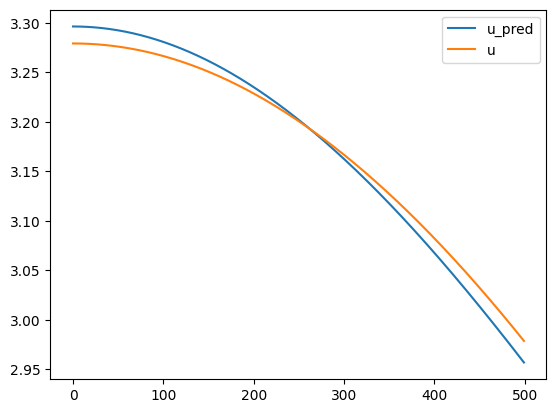

epoch 51 / 500 : loss = 8.166414260864258
epoch 52 / 500 : loss = 7.837719917297363
epoch 53 / 500 : loss = 7.524362564086914
epoch 54 / 500 : loss = 7.225394248962402


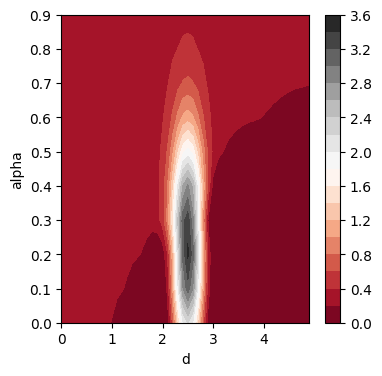

epoch 55 / 500 : loss = 6.939953327178955


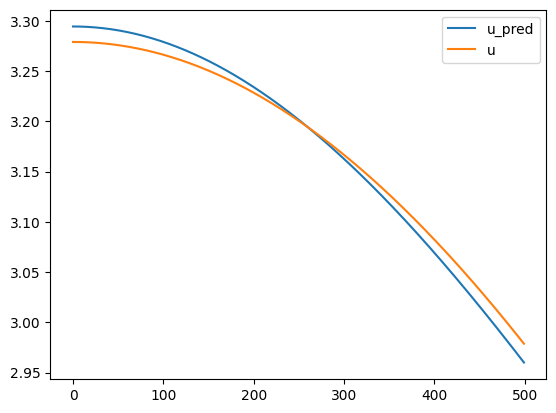

epoch 56 / 500 : loss = 6.667287826538086
epoch 57 / 500 : loss = 6.406652450561523
epoch 58 / 500 : loss = 6.1576128005981445
epoch 59 / 500 : loss = 5.9195451736450195


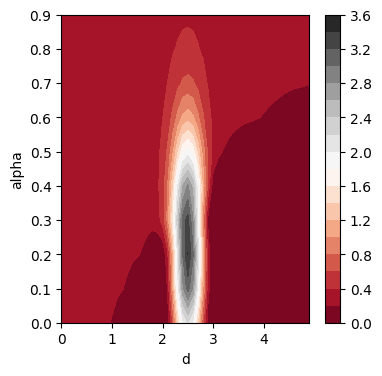

epoch 60 / 500 : loss = 5.691791534423828


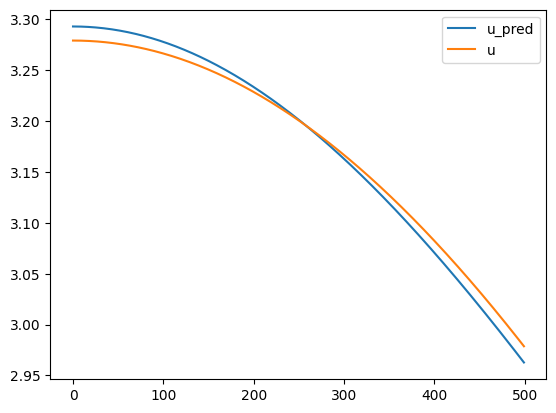

epoch 61 / 500 : loss = 5.473790168762207
epoch 62 / 500 : loss = 5.265036582946777
epoch 63 / 500 : loss = 5.065104961395264
epoch 64 / 500 : loss = 4.873534202575684


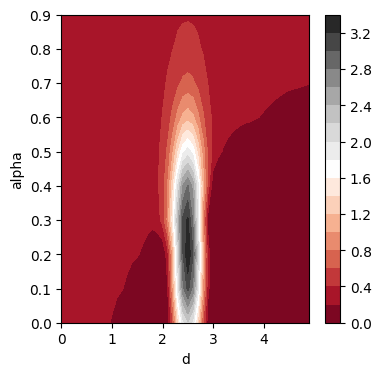

epoch 65 / 500 : loss = 4.689932823181152


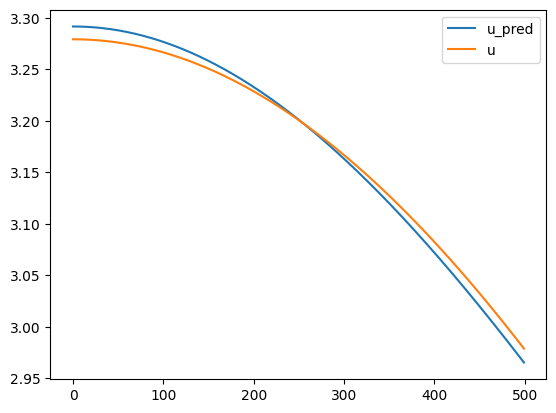

epoch 66 / 500 : loss = 4.513919830322266
epoch 67 / 500 : loss = 4.3451828956604
epoch 68 / 500 : loss = 4.183345794677734
epoch 69 / 500 : loss = 4.028088569641113


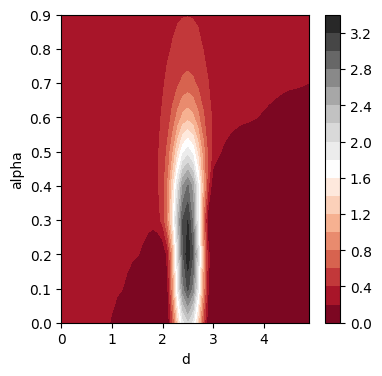

epoch 70 / 500 : loss = 3.879122257232666


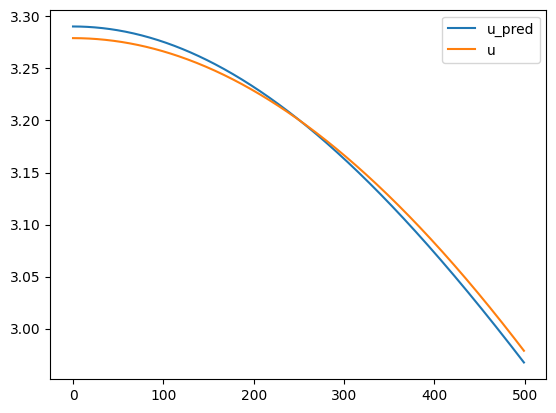

epoch 71 / 500 : loss = 3.7361621856689453
epoch 72 / 500 : loss = 3.5989251136779785
epoch 73 / 500 : loss = 3.467111110687256
epoch 74 / 500 : loss = 3.340503215789795


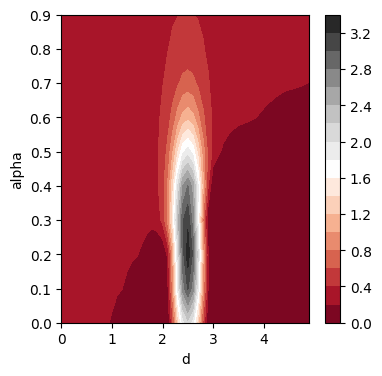

epoch 75 / 500 : loss = 3.2188780307769775


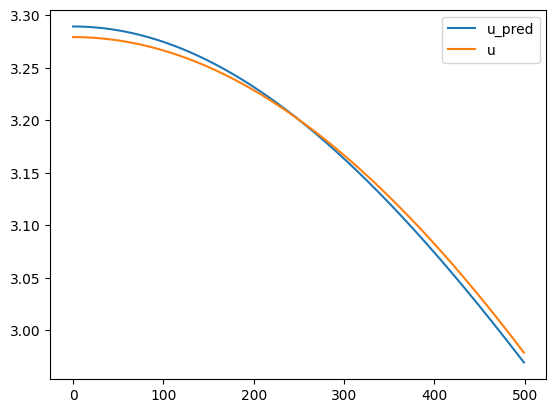

epoch 76 / 500 : loss = 3.1020164489746094
epoch 77 / 500 : loss = 2.989708185195923
epoch 78 / 500 : loss = 2.881743907928467
epoch 79 / 500 : loss = 2.7779760360717773


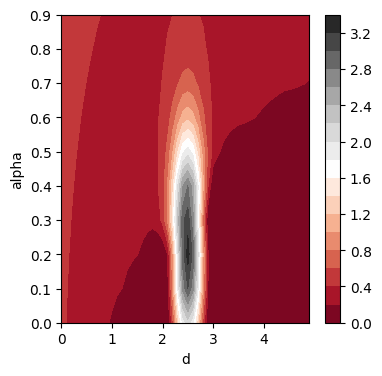

epoch 80 / 500 : loss = 2.678231716156006


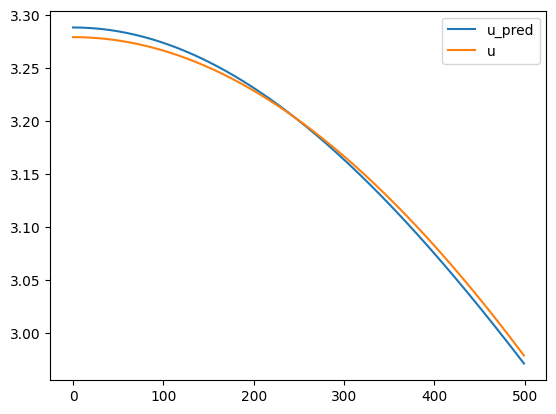

epoch 81 / 500 : loss = 2.5823755264282227
epoch 82 / 500 : loss = 2.490227699279785
epoch 83 / 500 : loss = 2.4016833305358887
epoch 84 / 500 : loss = 2.316689968109131


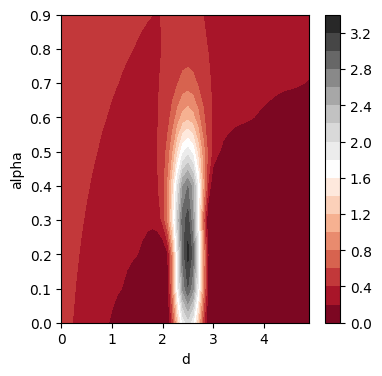

epoch 85 / 500 : loss = 2.2350330352783203


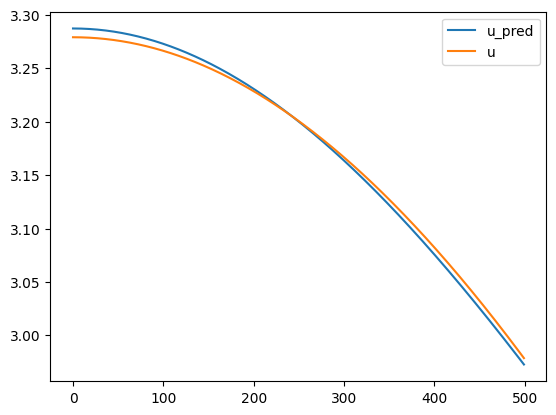

epoch 86 / 500 : loss = 2.156521797180176
epoch 87 / 500 : loss = 2.081205368041992
epoch 88 / 500 : loss = 2.008882522583008
epoch 89 / 500 : loss = 1.9394023418426514


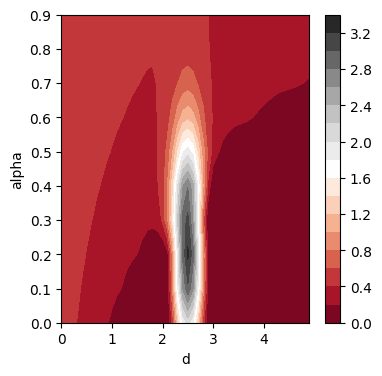

epoch 90 / 500 : loss = 1.8726682662963867


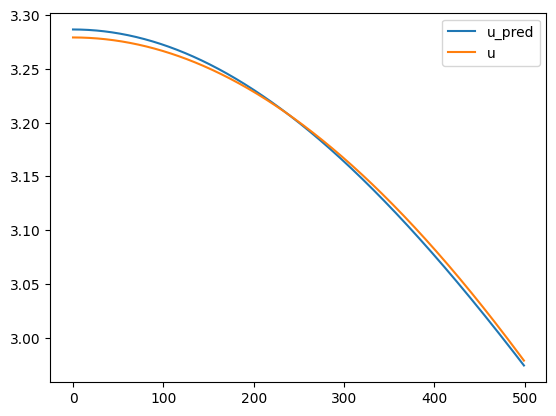

epoch 91 / 500 : loss = 1.8085649013519287
epoch 92 / 500 : loss = 1.7469775676727295
epoch 93 / 500 : loss = 1.6877903938293457
epoch 94 / 500 : loss = 1.630887746810913


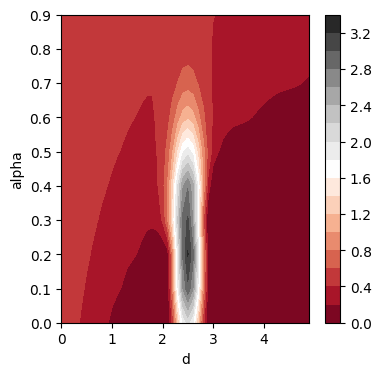

epoch 95 / 500 : loss = 1.5761127471923828


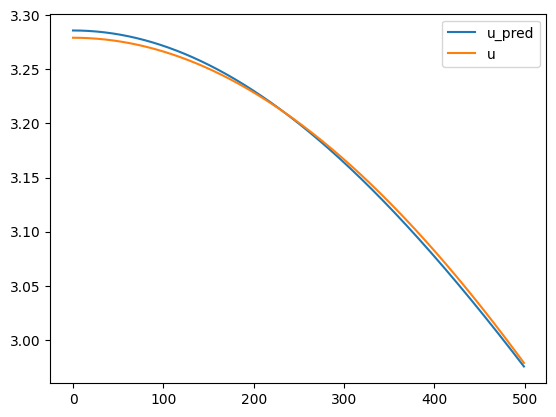

epoch 96 / 500 : loss = 1.52337646484375
epoch 97 / 500 : loss = 1.4725978374481201
epoch 98 / 500 : loss = 1.4237000942230225
epoch 99 / 500 : loss = 1.3766205310821533


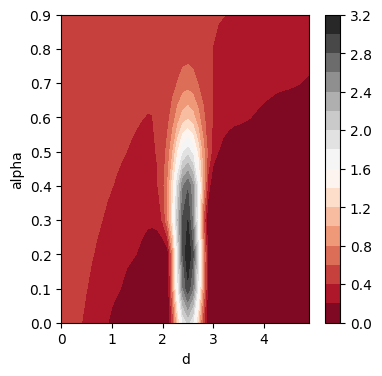

epoch 100 / 500 : loss = 1.3312928676605225


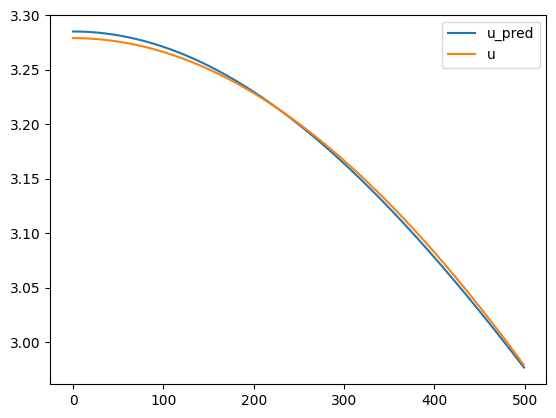

epoch 101 / 500 : loss = 1.287642240524292
epoch 102 / 500 : loss = 1.2456116676330566
epoch 103 / 500 : loss = 1.205143928527832
epoch 104 / 500 : loss = 1.1661862134933472


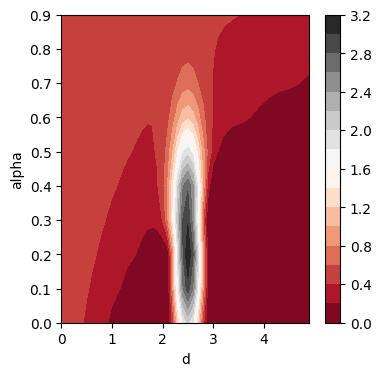

epoch 105 / 500 : loss = 1.1286779642105103


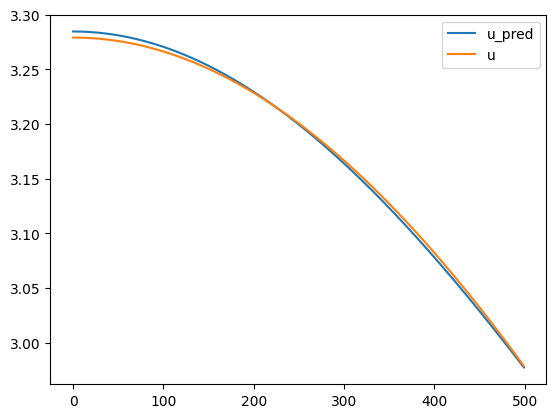

epoch 106 / 500 : loss = 1.0925639867782593
epoch 107 / 500 : loss = 1.0578027963638306
epoch 108 / 500 : loss = 1.024343729019165
epoch 109 / 500 : loss = 0.9921362996101379


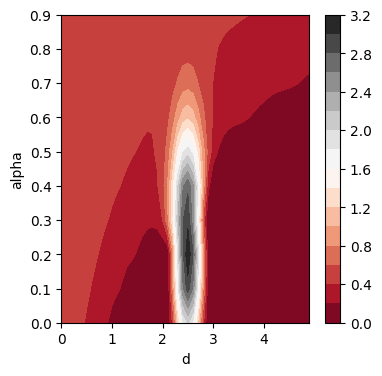

epoch 110 / 500 : loss = 0.9611334204673767


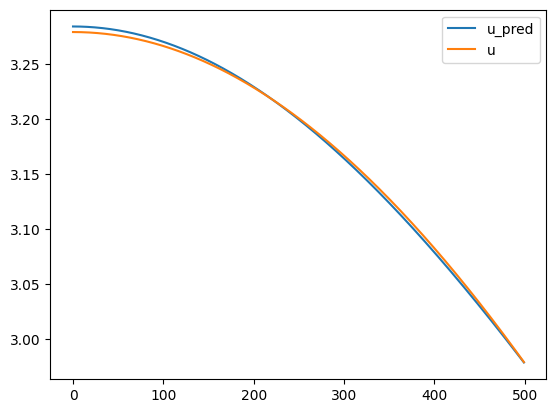

epoch 111 / 500 : loss = 0.9312934279441833
epoch 112 / 500 : loss = 0.9025737047195435
epoch 113 / 500 : loss = 0.8749531507492065
epoch 114 / 500 : loss = 0.8485103845596313


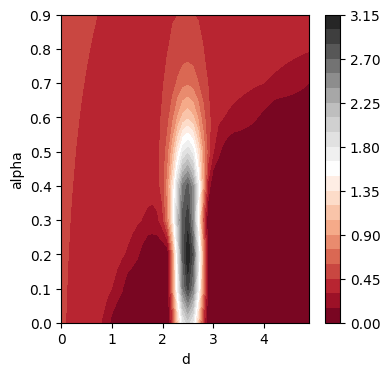

epoch 115 / 500 : loss = 0.8231092691421509


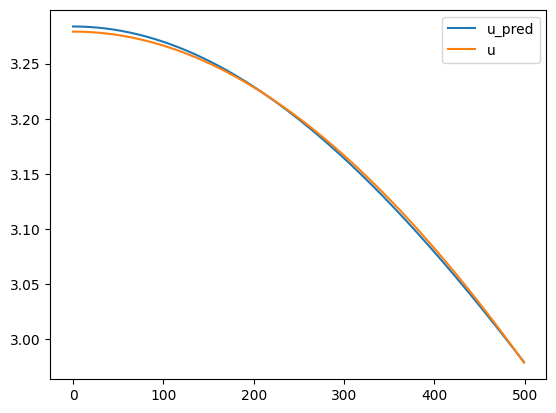

epoch 116 / 500 : loss = 0.7986934781074524
epoch 117 / 500 : loss = 0.7752156257629395
epoch 118 / 500 : loss = 0.7526363134384155
epoch 119 / 500 : loss = 0.7309221029281616


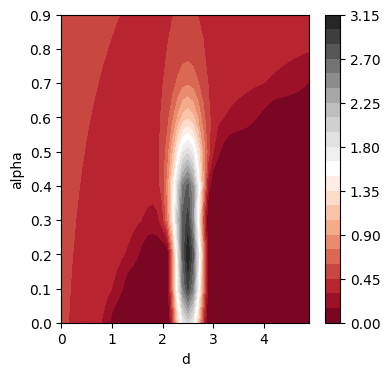

epoch 120 / 500 : loss = 0.7100406289100647


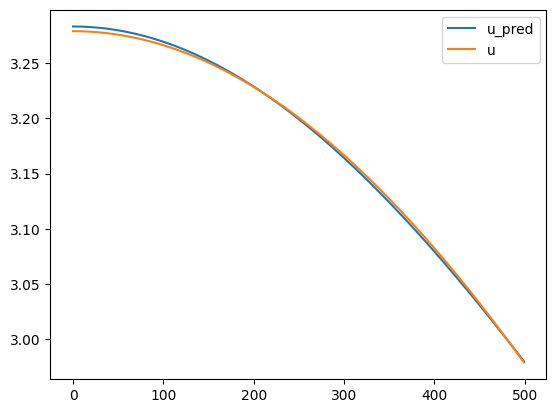

epoch 121 / 500 : loss = 0.6899586915969849
epoch 122 / 500 : loss = 0.6706411838531494
epoch 123 / 500 : loss = 0.6520466804504395
epoch 124 / 500 : loss = 0.6341482400894165


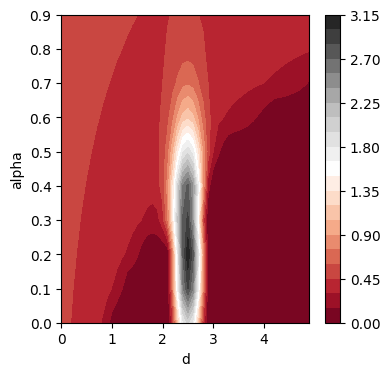

epoch 125 / 500 : loss = 0.6169204711914062


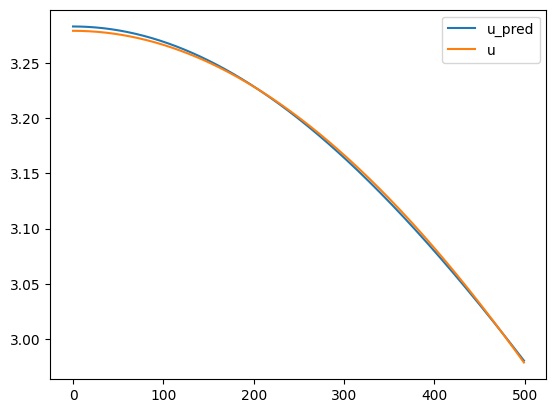

epoch 126 / 500 : loss = 0.6003400087356567
epoch 127 / 500 : loss = 0.5843849778175354
epoch 128 / 500 : loss = 0.5690316557884216
epoch 129 / 500 : loss = 0.5542588829994202


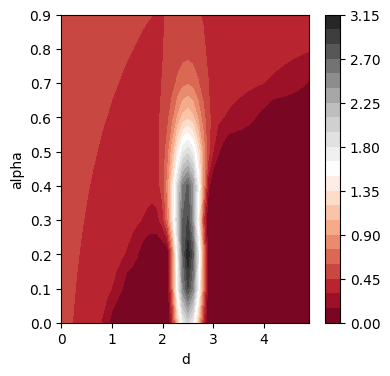

epoch 130 / 500 : loss = 0.5400443077087402


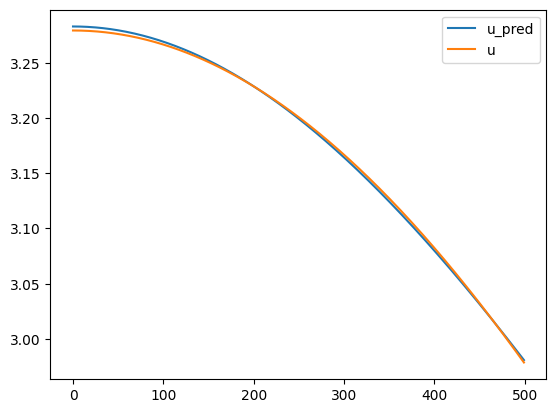

epoch 131 / 500 : loss = 0.5263689756393433
epoch 132 / 500 : loss = 0.5132127404212952
epoch 133 / 500 : loss = 0.5005562901496887
epoch 134 / 500 : loss = 0.4883837103843689


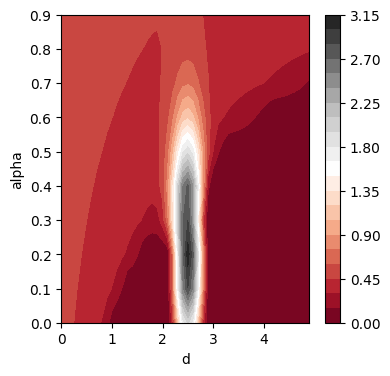

epoch 135 / 500 : loss = 0.4766758978366852


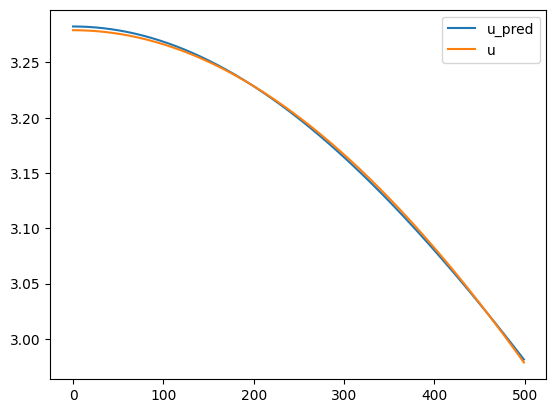

epoch 136 / 500 : loss = 0.4654196798801422
epoch 137 / 500 : loss = 0.45459532737731934
epoch 138 / 500 : loss = 0.44418466091156006
epoch 139 / 500 : loss = 0.4341764748096466


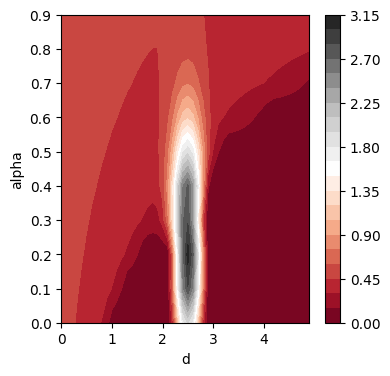

epoch 140 / 500 : loss = 0.42455270886421204


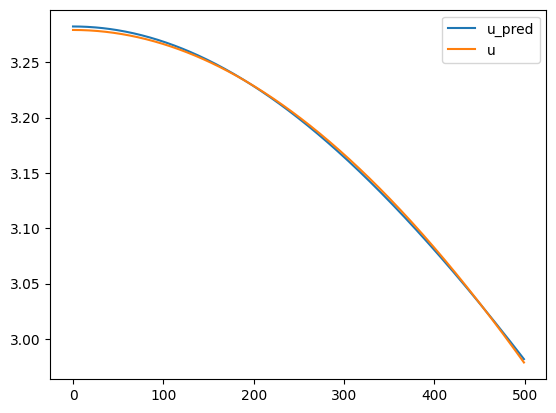

epoch 141 / 500 : loss = 0.41530001163482666
epoch 142 / 500 : loss = 0.4064074158668518
epoch 143 / 500 : loss = 0.39786067605018616
epoch 144 / 500 : loss = 0.38964658975601196


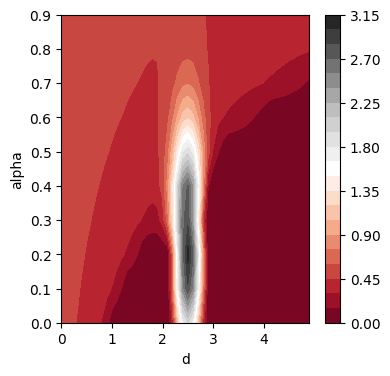

epoch 145 / 500 : loss = 0.38175302743911743


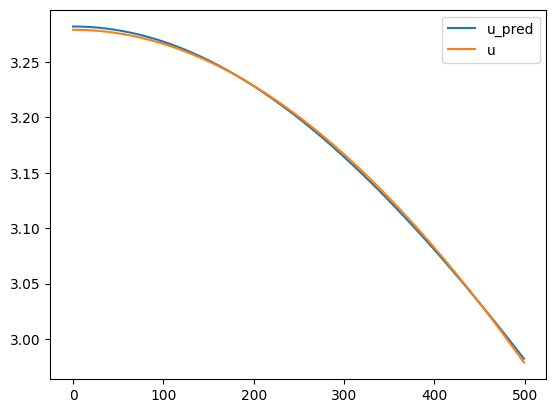

epoch 146 / 500 : loss = 0.3741679787635803
epoch 147 / 500 : loss = 0.36688071489334106
epoch 148 / 500 : loss = 0.35988032817840576
epoch 149 / 500 : loss = 0.3531572222709656


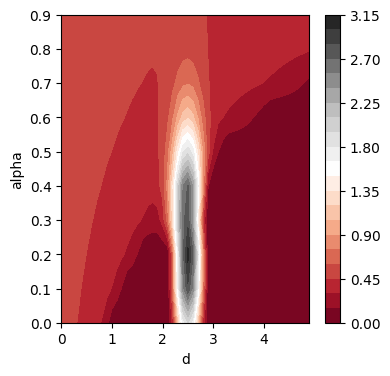

epoch 150 / 500 : loss = 0.3467002809047699


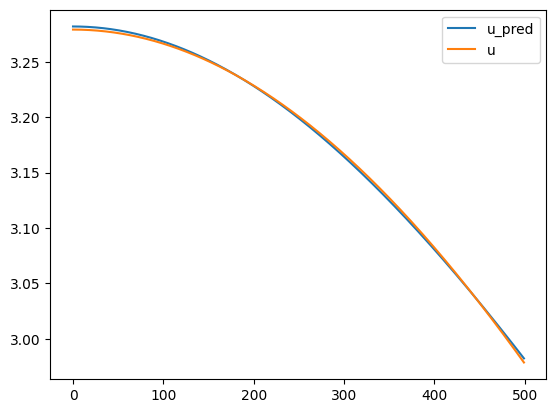

epoch 151 / 500 : loss = 0.34049874544143677
epoch 152 / 500 : loss = 0.3345436453819275
epoch 153 / 500 : loss = 0.3288259208202362
epoch 154 / 500 : loss = 0.3233361542224884


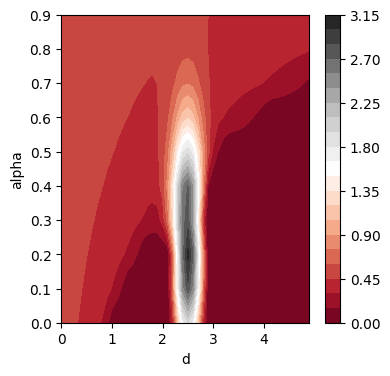

epoch 155 / 500 : loss = 0.3180672526359558


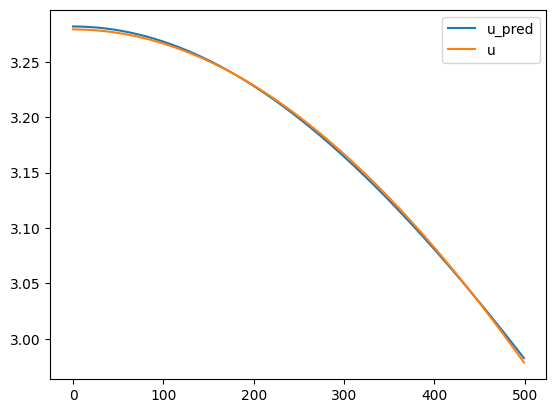

epoch 156 / 500 : loss = 0.31300947070121765
epoch 157 / 500 : loss = 0.3081570863723755
epoch 158 / 500 : loss = 0.3035006821155548
epoch 159 / 500 : loss = 0.29903244972229004


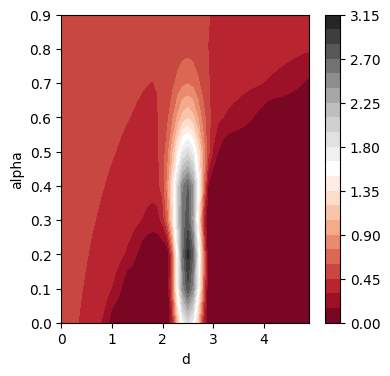

epoch 160 / 500 : loss = 0.2947464883327484


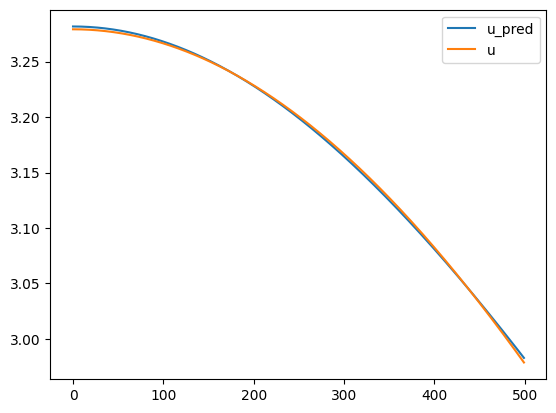

epoch 161 / 500 : loss = 0.2906356751918793
epoch 162 / 500 : loss = 0.286692351102829
epoch 163 / 500 : loss = 0.2829113304615021
epoch 164 / 500 : loss = 0.2793073058128357


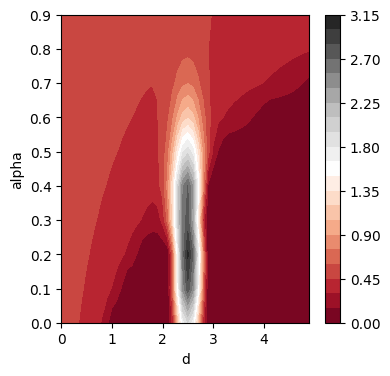

epoch 165 / 500 : loss = 0.275863915681839


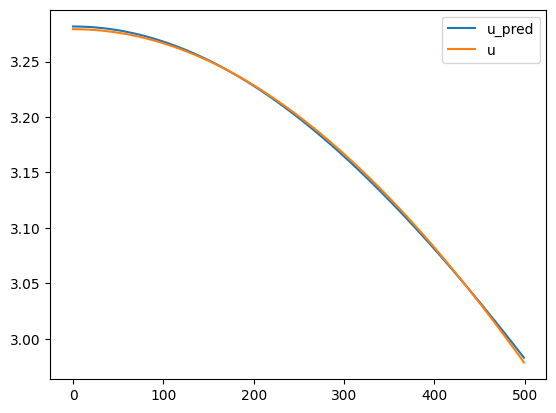

epoch 166 / 500 : loss = 0.27257078886032104
epoch 167 / 500 : loss = 0.26941820979118347
epoch 168 / 500 : loss = 0.26639682054519653
epoch 169 / 500 : loss = 0.2635065019130707


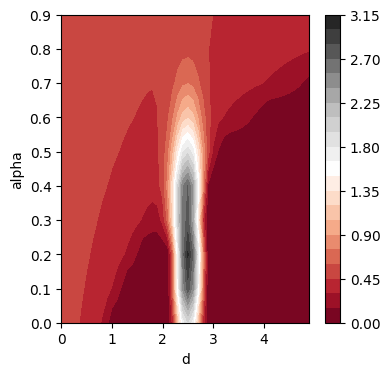

epoch 170 / 500 : loss = 0.2607437074184418


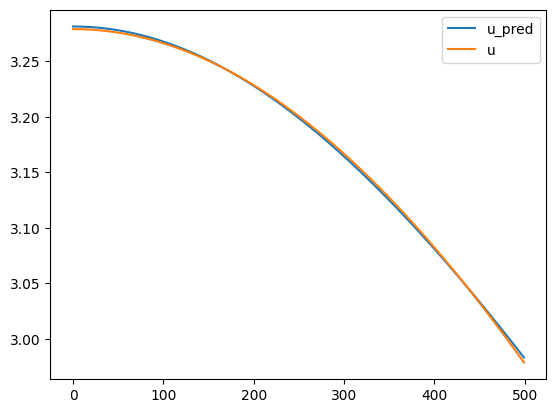

epoch 171 / 500 : loss = 0.2580995261669159
epoch 172 / 500 : loss = 0.255569726228714
epoch 173 / 500 : loss = 0.25314751267433167
epoch 174 / 500 : loss = 0.2508282959461212


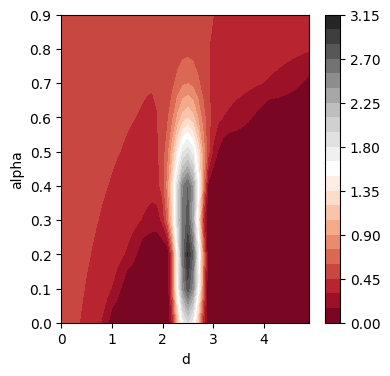

epoch 175 / 500 : loss = 0.24860888719558716


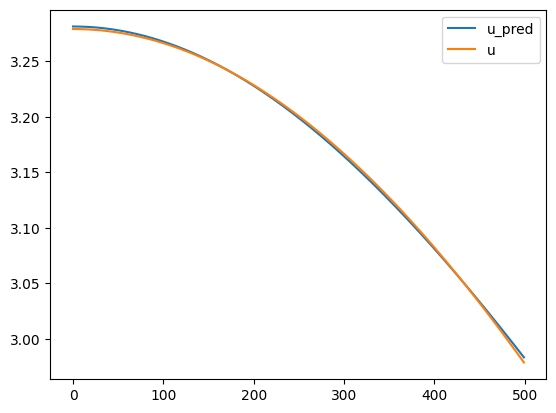

epoch 176 / 500 : loss = 0.24648363888263702
epoch 177 / 500 : loss = 0.24444925785064697
epoch 178 / 500 : loss = 0.24250122904777527
epoch 179 / 500 : loss = 0.24063734710216522


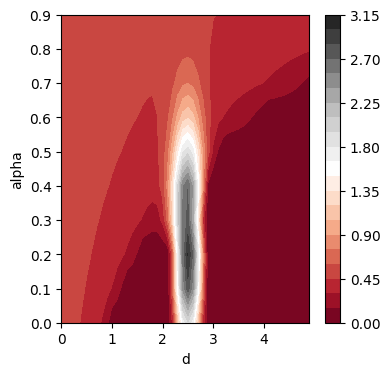

epoch 180 / 500 : loss = 0.2388516664505005


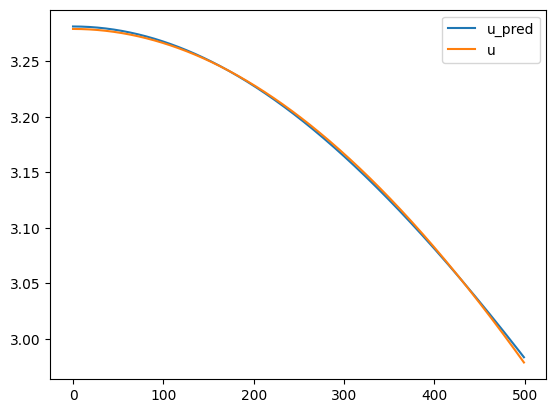

epoch 181 / 500 : loss = 0.2371421754360199
epoch 182 / 500 : loss = 0.23550617694854736
epoch 183 / 500 : loss = 0.23394005000591278
epoch 184 / 500 : loss = 0.23243996500968933


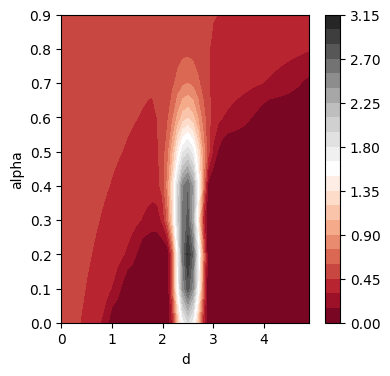

epoch 185 / 500 : loss = 0.2310047298669815


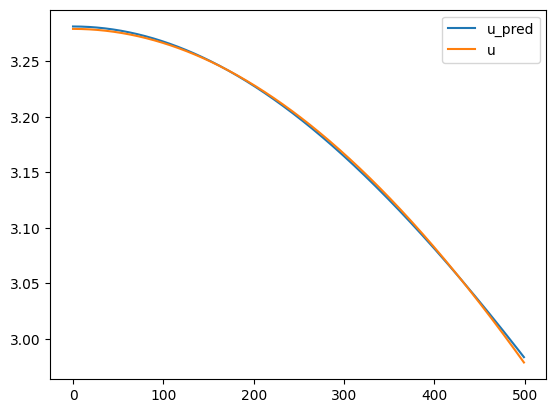

epoch 186 / 500 : loss = 0.22963018715381622
epoch 187 / 500 : loss = 0.22831487655639648
epoch 188 / 500 : loss = 0.2270543873310089
epoch 189 / 500 : loss = 0.22584819793701172


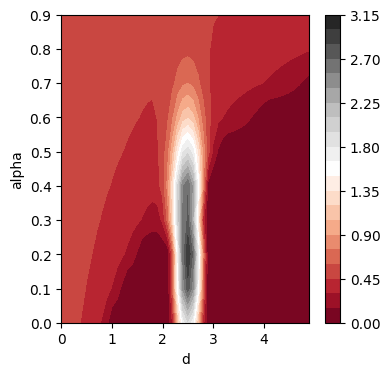

epoch 190 / 500 : loss = 0.22469177842140198


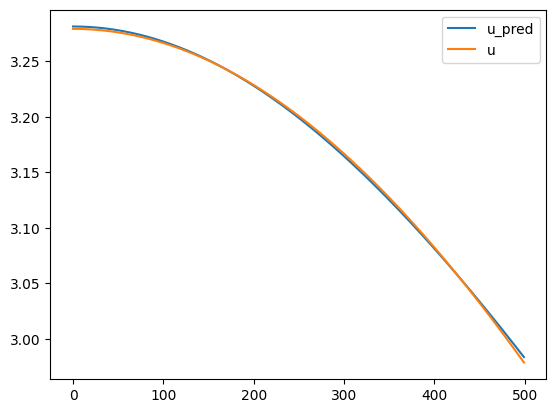

epoch 191 / 500 : loss = 0.2235850989818573
epoch 192 / 500 : loss = 0.2225247323513031
epoch 193 / 500 : loss = 0.22151009738445282
epoch 194 / 500 : loss = 0.22053751349449158


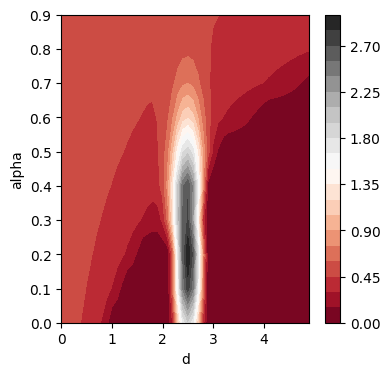

epoch 195 / 500 : loss = 0.21960705518722534


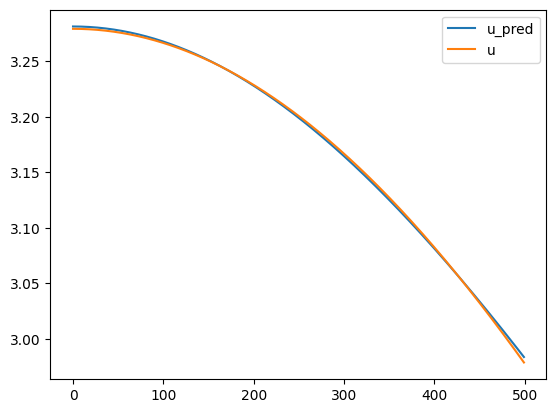

epoch 196 / 500 : loss = 0.21871554851531982
epoch 197 / 500 : loss = 0.21786238253116608
epoch 198 / 500 : loss = 0.21704556047916412
epoch 199 / 500 : loss = 0.2162633240222931


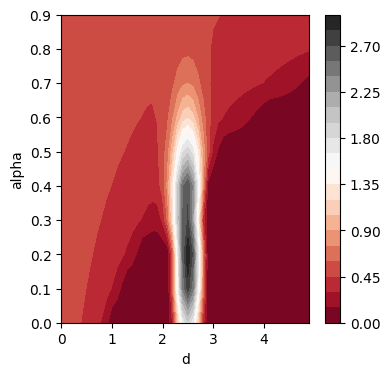

epoch 200 / 500 : loss = 0.21551500260829926


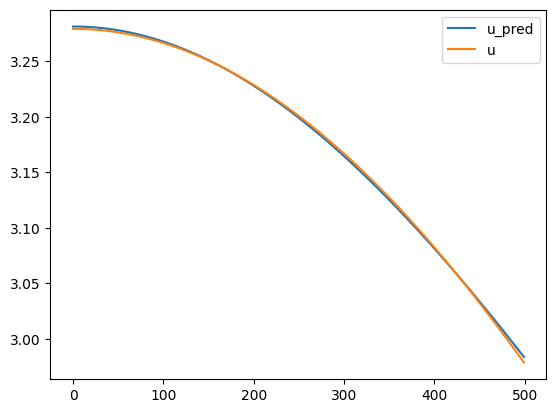

epoch 201 / 500 : loss = 0.2147984504699707
epoch 202 / 500 : loss = 0.21411265432834625
epoch 203 / 500 : loss = 0.21345582604408264
epoch 204 / 500 : loss = 0.21282775700092316


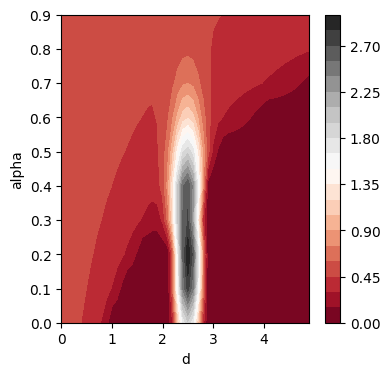

epoch 205 / 500 : loss = 0.21222636103630066


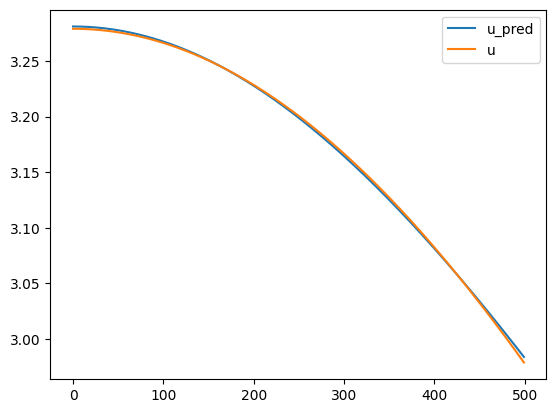

epoch 206 / 500 : loss = 0.21165108680725098
epoch 207 / 500 : loss = 0.2111004889011383
epoch 208 / 500 : loss = 0.2105734944343567
epoch 209 / 500 : loss = 0.21006929874420166


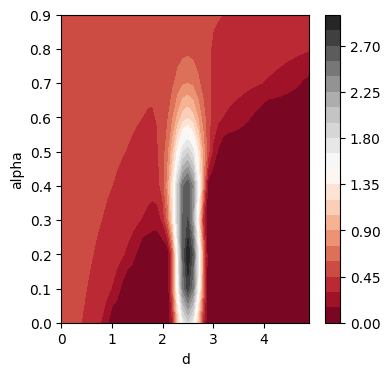

epoch 210 / 500 : loss = 0.20958639681339264


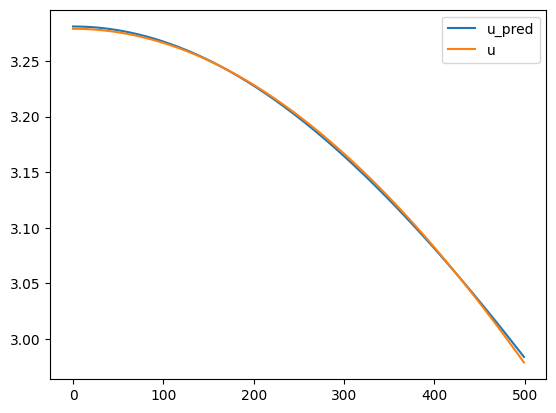

epoch 211 / 500 : loss = 0.20912478864192963
epoch 212 / 500 : loss = 0.20868271589279175
epoch 213 / 500 : loss = 0.20826002955436707
epoch 214 / 500 : loss = 0.2078549712896347


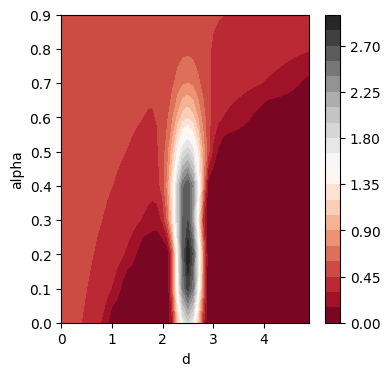

epoch 215 / 500 : loss = 0.20746755599975586


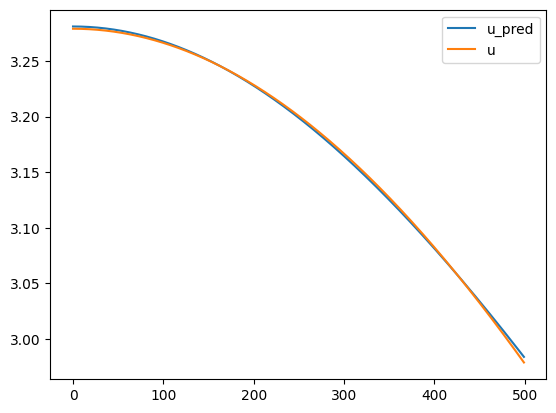

epoch 216 / 500 : loss = 0.20709730684757233
epoch 217 / 500 : loss = 0.20674271881580353
epoch 218 / 500 : loss = 0.2064034789800644
epoch 219 / 500 : loss = 0.20607873797416687


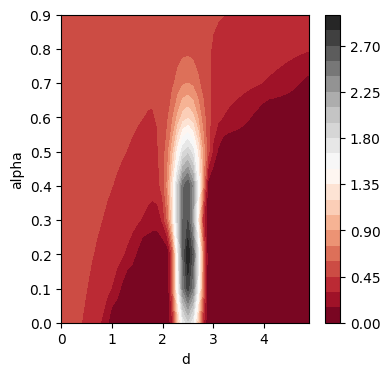

epoch 220 / 500 : loss = 0.2057679146528244


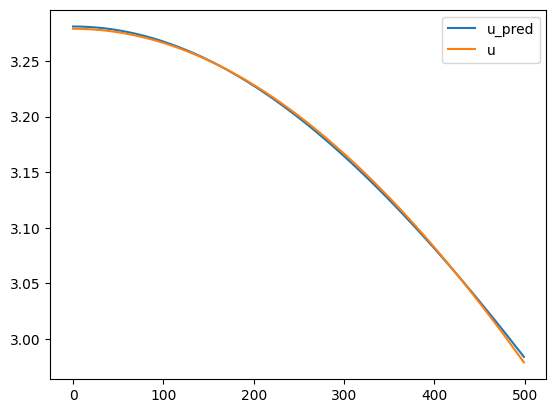

epoch 221 / 500 : loss = 0.20547045767307281
epoch 222 / 500 : loss = 0.20518608391284943
epoch 223 / 500 : loss = 0.20491395890712738
epoch 224 / 500 : loss = 0.20465314388275146


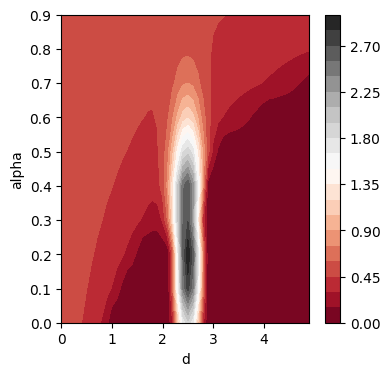

epoch 225 / 500 : loss = 0.2044036090373993


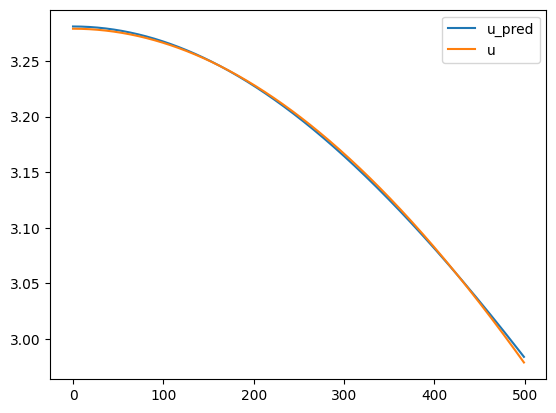

epoch 226 / 500 : loss = 0.20416447520256042
epoch 227 / 500 : loss = 0.2039356678724289
epoch 228 / 500 : loss = 0.2037167102098465
epoch 229 / 500 : loss = 0.20350658893585205


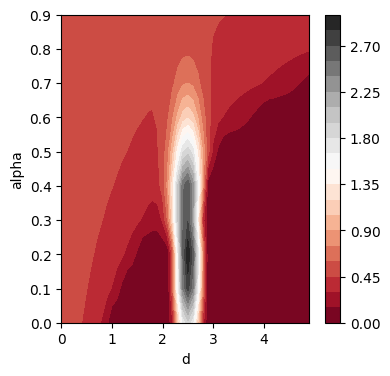

epoch 230 / 500 : loss = 0.2033054083585739


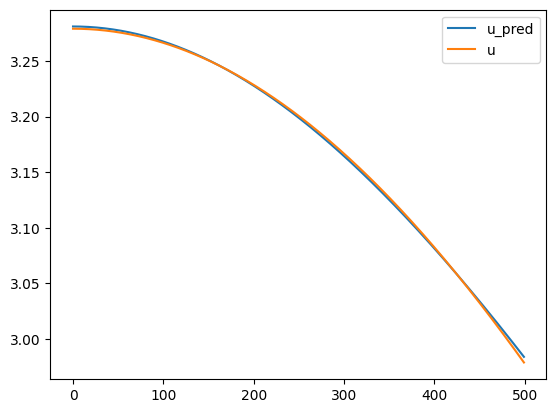

epoch 231 / 500 : loss = 0.20311257243156433
epoch 232 / 500 : loss = 0.20292805135250092
epoch 233 / 500 : loss = 0.20275172591209412
epoch 234 / 500 : loss = 0.20258191227912903


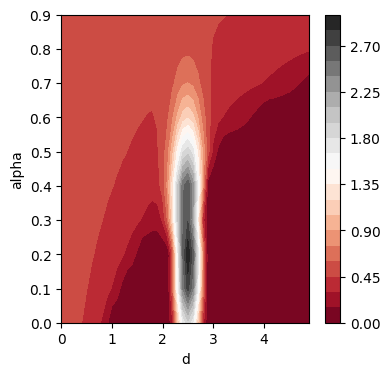

epoch 235 / 500 : loss = 0.20241951942443848


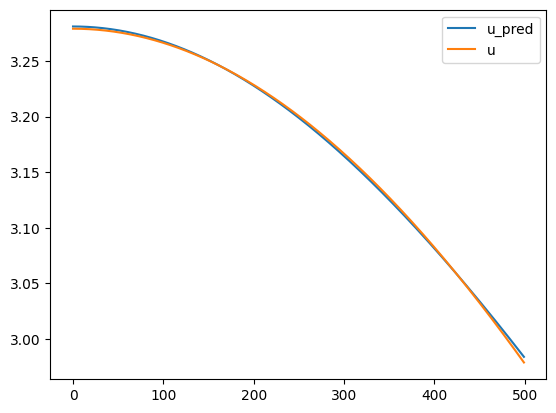

epoch 236 / 500 : loss = 0.20226381719112396
epoch 237 / 500 : loss = 0.20211438834667206
epoch 238 / 500 : loss = 0.20197075605392456
epoch 239 / 500 : loss = 0.2018333524465561


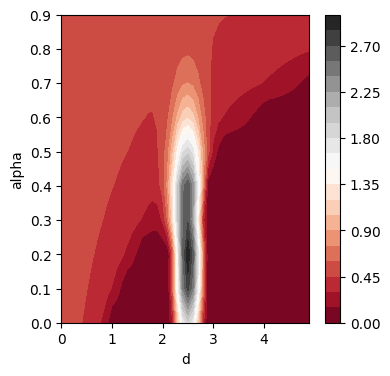

epoch 240 / 500 : loss = 0.20170147716999054


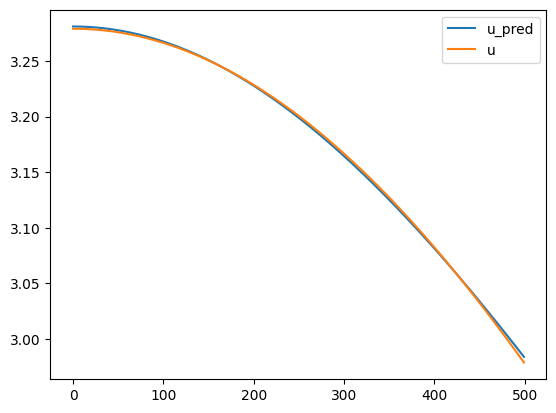

epoch 241 / 500 : loss = 0.20157486200332642
epoch 242 / 500 : loss = 0.20145273208618164
epoch 243 / 500 : loss = 0.20133595168590546
epoch 244 / 500 : loss = 0.20122332870960236


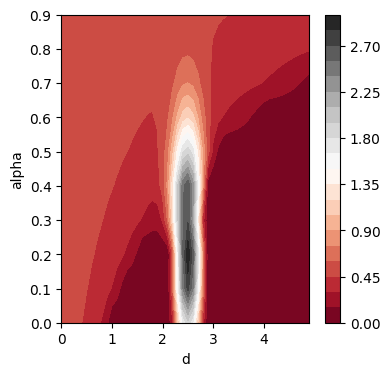

epoch 245 / 500 : loss = 0.20111525058746338


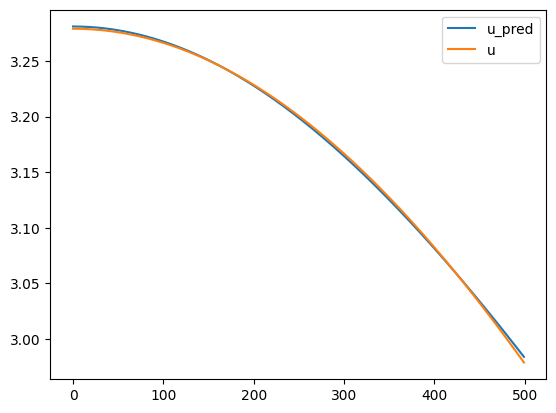

epoch 246 / 500 : loss = 0.2010113000869751
epoch 247 / 500 : loss = 0.2009110301733017
epoch 248 / 500 : loss = 0.20081479847431183
epoch 249 / 500 : loss = 0.20072215795516968


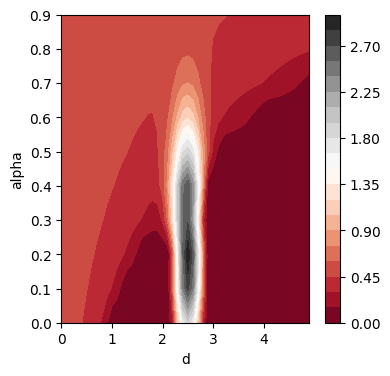

epoch 250 / 500 : loss = 0.200632706284523


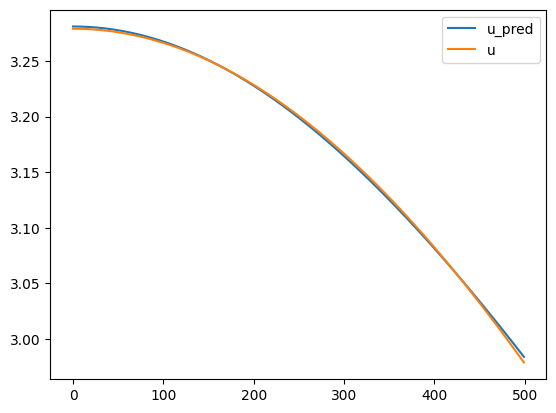

epoch 251 / 500 : loss = 0.20054665207862854
epoch 252 / 500 : loss = 0.20046287775039673
epoch 253 / 500 : loss = 0.20038296282291412
epoch 254 / 500 : loss = 0.20030543208122253


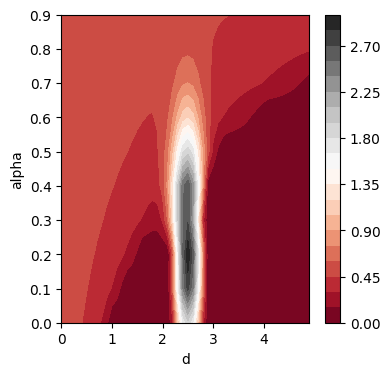

epoch 255 / 500 : loss = 0.20023061335086823


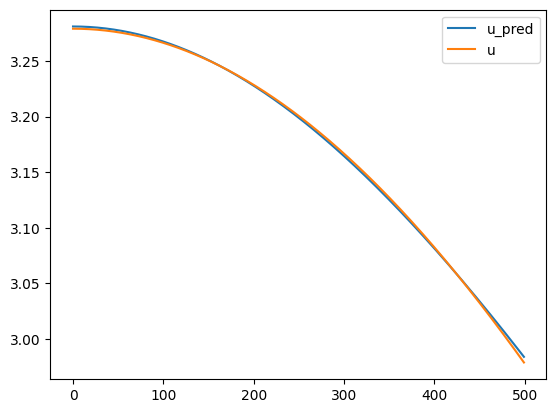

epoch 256 / 500 : loss = 0.20015811920166016
epoch 257 / 500 : loss = 0.2000885158777237
epoch 258 / 500 : loss = 0.20002061128616333
epoch 259 / 500 : loss = 0.1999550610780716


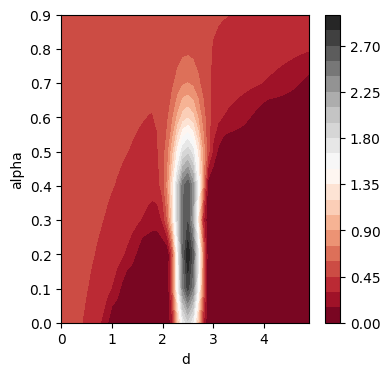

epoch 260 / 500 : loss = 0.1998913586139679


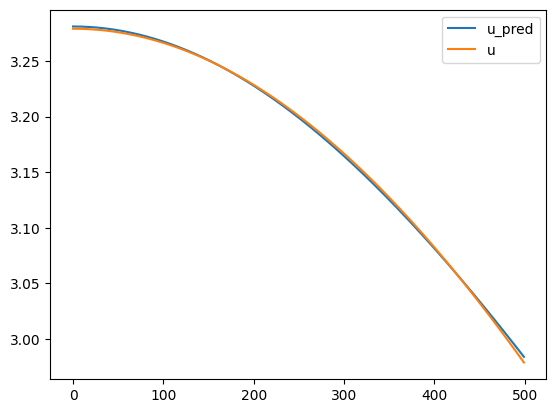

epoch 261 / 500 : loss = 0.19983024895191193
epoch 262 / 500 : loss = 0.19977012276649475
epoch 263 / 500 : loss = 0.1997125744819641
epoch 264 / 500 : loss = 0.19965621829032898


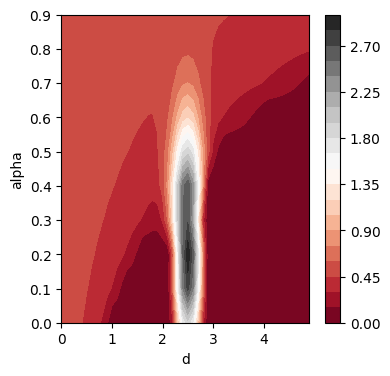

epoch 265 / 500 : loss = 0.19960173964500427


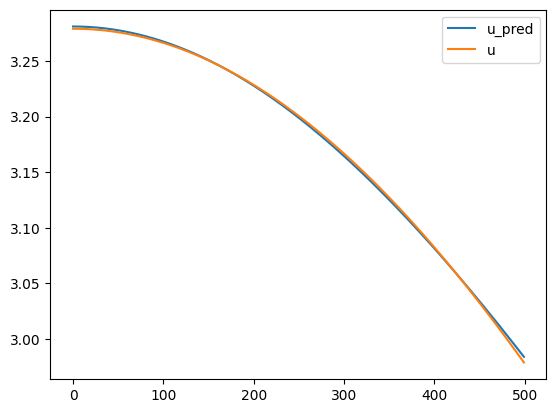

epoch 266 / 500 : loss = 0.1995486617088318
epoch 267 / 500 : loss = 0.19949617981910706
epoch 268 / 500 : loss = 0.19944560527801514
epoch 269 / 500 : loss = 0.19939662516117096


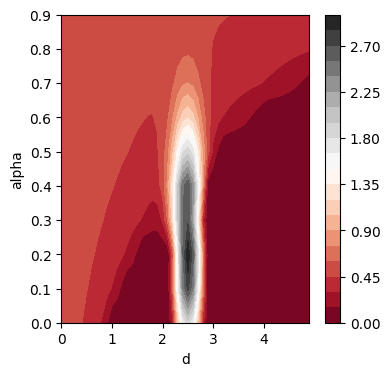

epoch 270 / 500 : loss = 0.19934861361980438


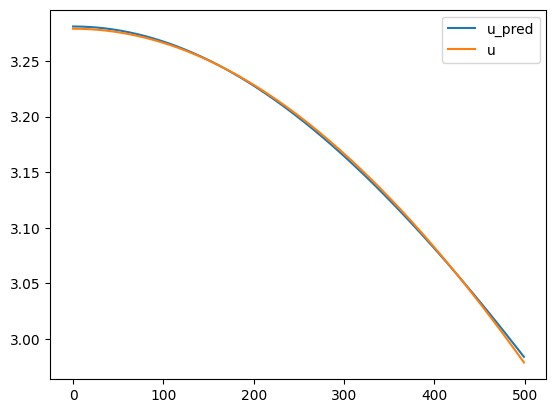

epoch 271 / 500 : loss = 0.1993022859096527
epoch 272 / 500 : loss = 0.19925668835639954
epoch 273 / 500 : loss = 0.1992119997739792
epoch 274 / 500 : loss = 0.19916820526123047


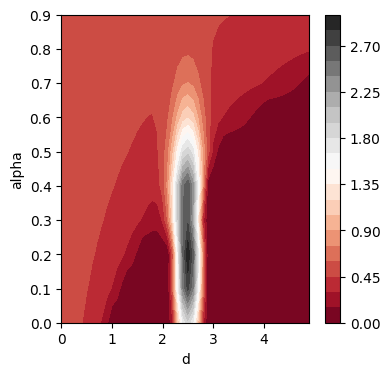

epoch 275 / 500 : loss = 0.1991257518529892


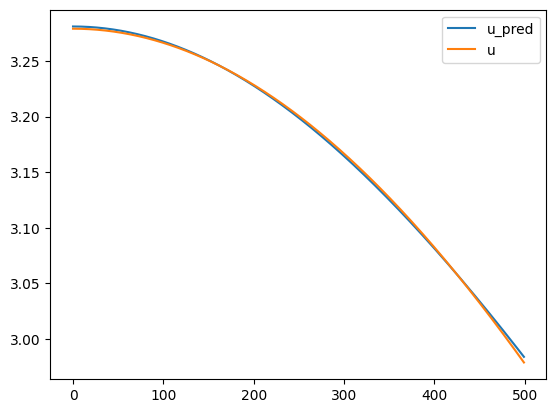

epoch 276 / 500 : loss = 0.19908373057842255
epoch 277 / 500 : loss = 0.1990429311990738
epoch 278 / 500 : loss = 0.1990026980638504
epoch 279 / 500 : loss = 0.1989632397890091


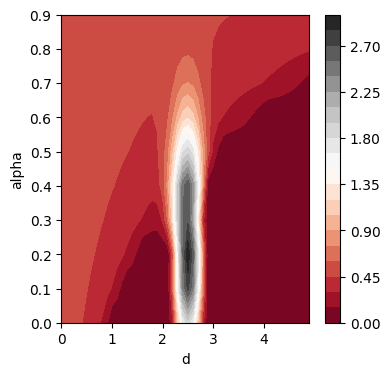

epoch 280 / 500 : loss = 0.1989241987466812


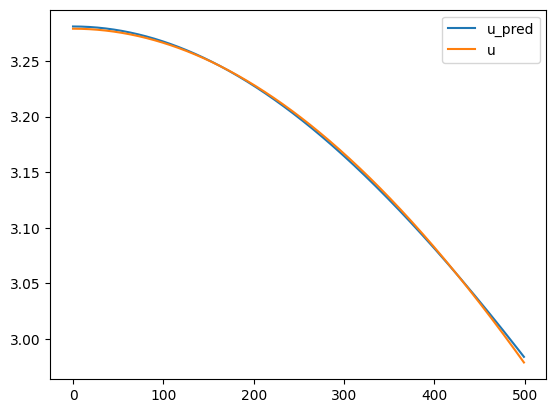

epoch 281 / 500 : loss = 0.19888657331466675
epoch 282 / 500 : loss = 0.19884848594665527
epoch 283 / 500 : loss = 0.1988118439912796
epoch 284 / 500 : loss = 0.1987755000591278


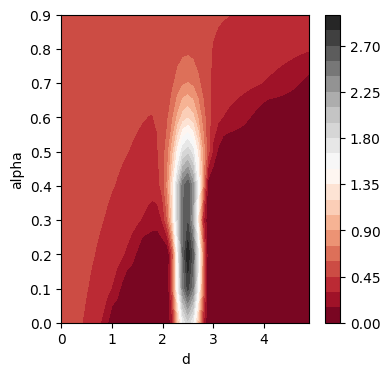

epoch 285 / 500 : loss = 0.19873978197574615


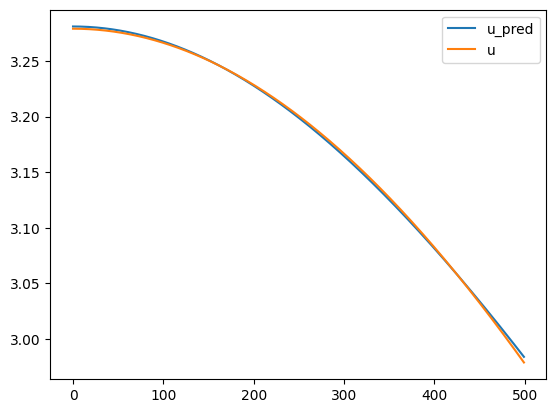

epoch 286 / 500 : loss = 0.1987040936946869
epoch 287 / 500 : loss = 0.19866925477981567
epoch 288 / 500 : loss = 0.1986350417137146
epoch 289 / 500 : loss = 0.19860081374645233


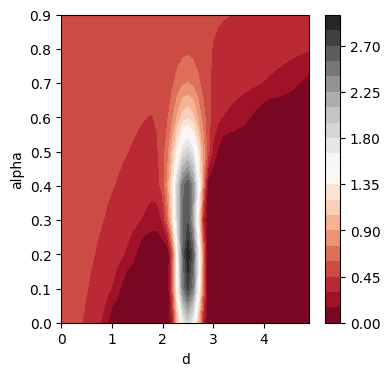

epoch 290 / 500 : loss = 0.1985670030117035


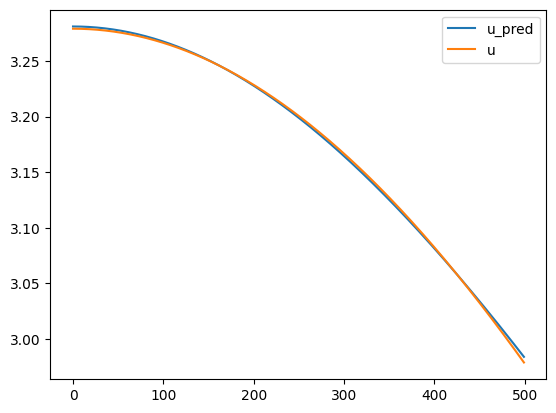

epoch 291 / 500 : loss = 0.1985337734222412
epoch 292 / 500 : loss = 0.19850102066993713
epoch 293 / 500 : loss = 0.19846825301647186
epoch 294 / 500 : loss = 0.19843582808971405


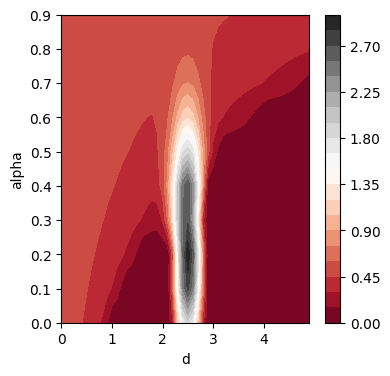

epoch 295 / 500 : loss = 0.19840393960475922


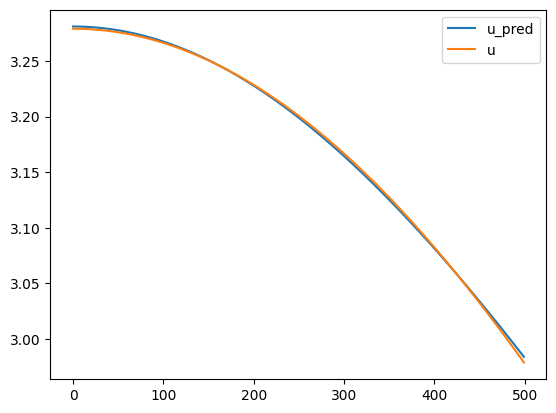

epoch 296 / 500 : loss = 0.19837217032909393
epoch 297 / 500 : loss = 0.19834080338478088
epoch 298 / 500 : loss = 0.19830955564975739
epoch 299 / 500 : loss = 0.1982785314321518


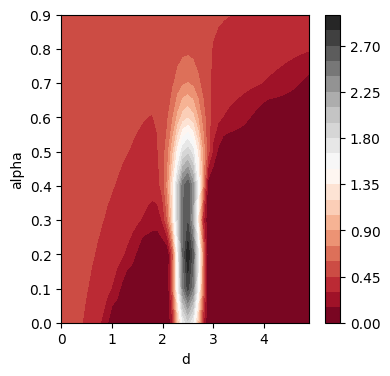

epoch 300 / 500 : loss = 0.19824761152267456


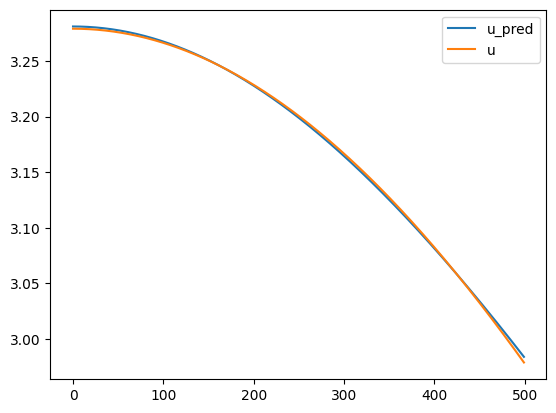

epoch 301 / 500 : loss = 0.1982170045375824
epoch 302 / 500 : loss = 0.19818657636642456
epoch 303 / 500 : loss = 0.1981567144393921
epoch 304 / 500 : loss = 0.19812624156475067


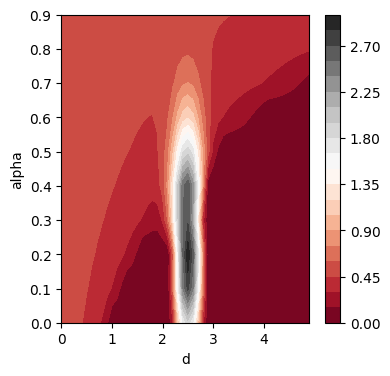

epoch 305 / 500 : loss = 0.1980961263179779


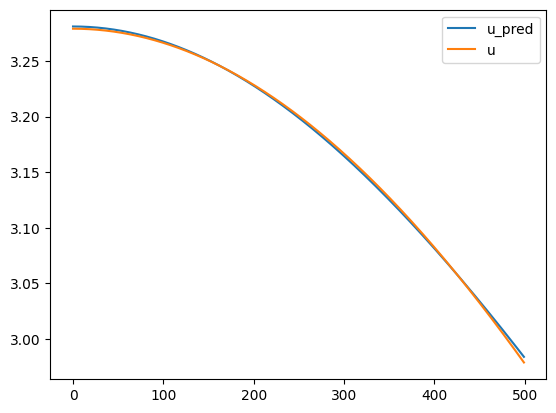

epoch 306 / 500 : loss = 0.19806665182113647
epoch 307 / 500 : loss = 0.19803647696971893
epoch 308 / 500 : loss = 0.19800692796707153
epoch 309 / 500 : loss = 0.19797731935977936


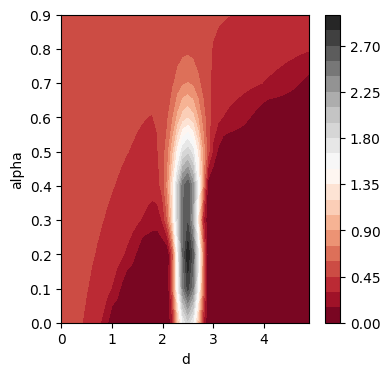

epoch 310 / 500 : loss = 0.19794818758964539


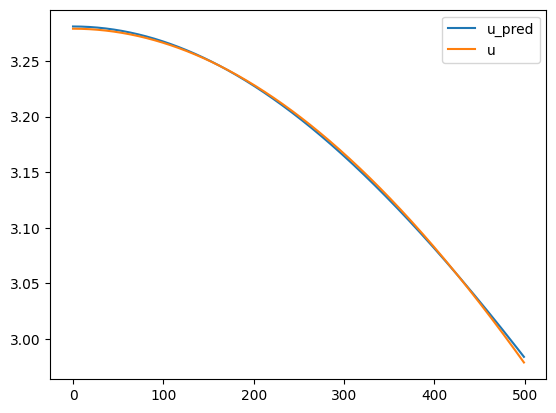

epoch 311 / 500 : loss = 0.19791863858699799
epoch 312 / 500 : loss = 0.19788987934589386
epoch 313 / 500 : loss = 0.1978604942560196
epoch 314 / 500 : loss = 0.19783146679401398


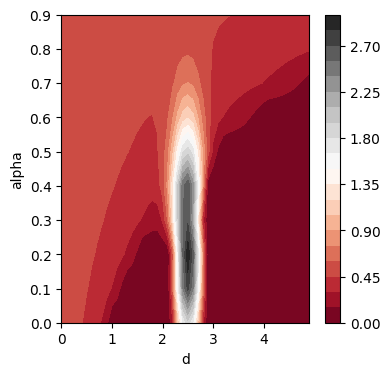

epoch 315 / 500 : loss = 0.19780206680297852


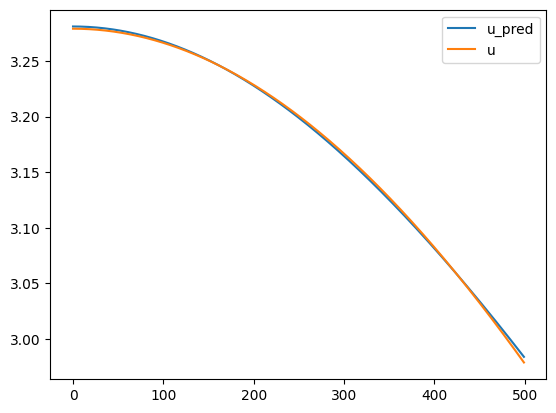

epoch 316 / 500 : loss = 0.1977730691432953
epoch 317 / 500 : loss = 0.19774432480335236
epoch 318 / 500 : loss = 0.19771507382392883
epoch 319 / 500 : loss = 0.19768674671649933


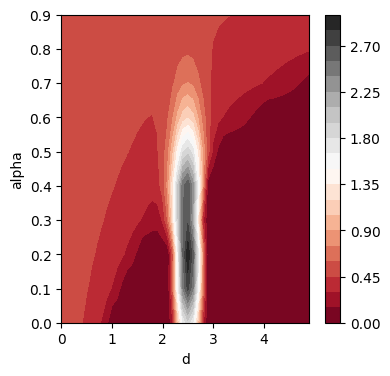

epoch 320 / 500 : loss = 0.1976574808359146


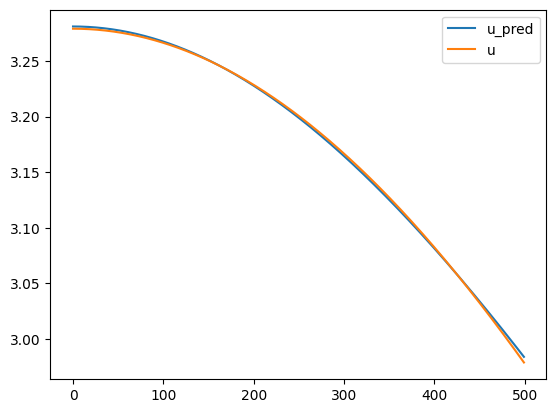

epoch 321 / 500 : loss = 0.19762937724590302
epoch 322 / 500 : loss = 0.19760020077228546
epoch 323 / 500 : loss = 0.19757124781608582
epoch 324 / 500 : loss = 0.1975429207086563


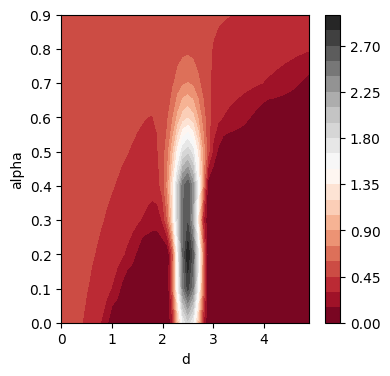

epoch 325 / 500 : loss = 0.1975143551826477


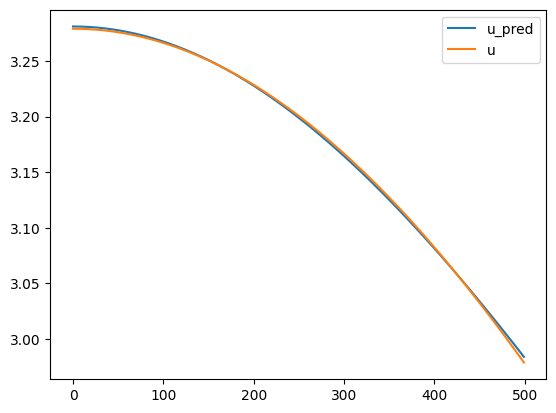

epoch 326 / 500 : loss = 0.19748550653457642
epoch 327 / 500 : loss = 0.1974574774503708
epoch 328 / 500 : loss = 0.19742915034294128
epoch 329 / 500 : loss = 0.19740065932273865


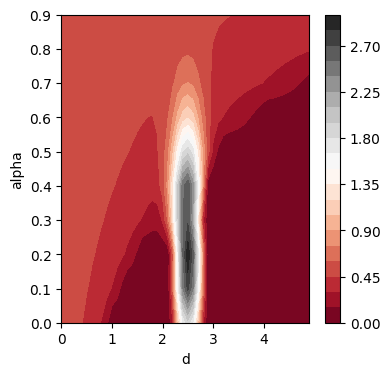

epoch 330 / 500 : loss = 0.1973722130060196


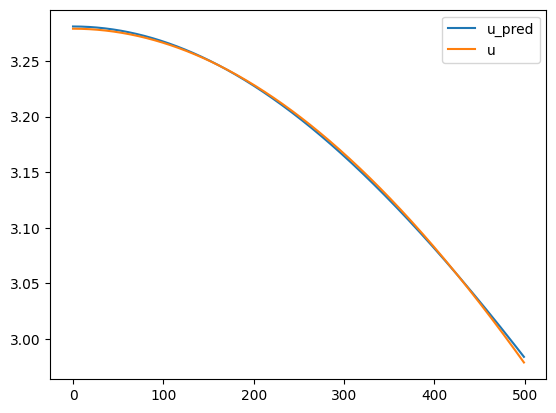

epoch 331 / 500 : loss = 0.19734397530555725
epoch 332 / 500 : loss = 0.19731581211090088
epoch 333 / 500 : loss = 0.19728730618953705
epoch 334 / 500 : loss = 0.19725927710533142


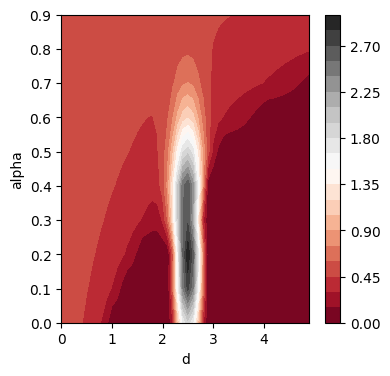

epoch 335 / 500 : loss = 0.1972309947013855


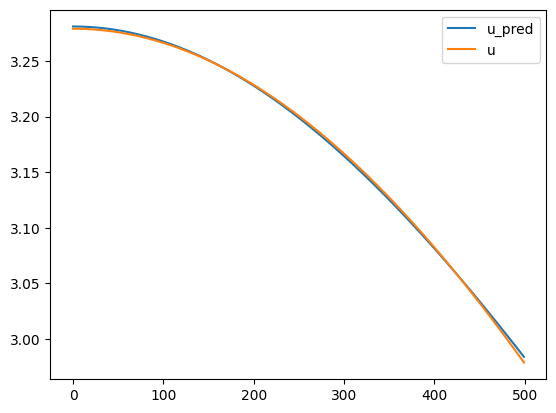

epoch 336 / 500 : loss = 0.19720302522182465
epoch 337 / 500 : loss = 0.19717520475387573
epoch 338 / 500 : loss = 0.1971469223499298
epoch 339 / 500 : loss = 0.19711905717849731


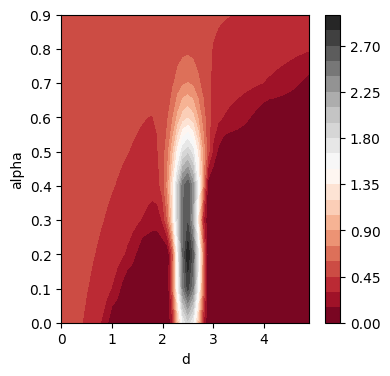

epoch 340 / 500 : loss = 0.19709080457687378


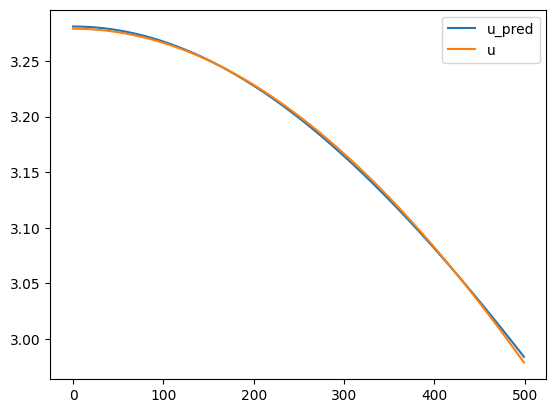

epoch 341 / 500 : loss = 0.1970621645450592
epoch 342 / 500 : loss = 0.19703426957130432
epoch 343 / 500 : loss = 0.1970062255859375
epoch 344 / 500 : loss = 0.1969781219959259


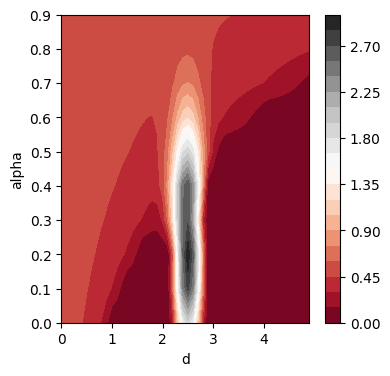

epoch 345 / 500 : loss = 0.1969497799873352


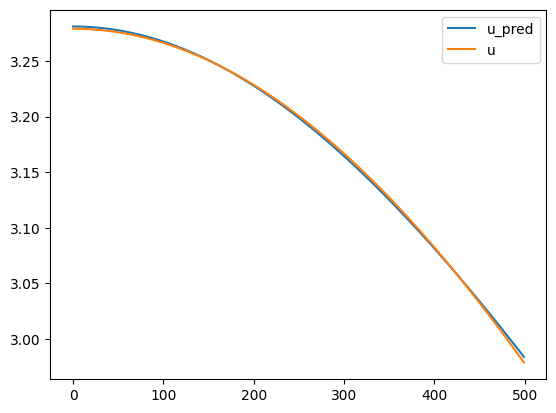

epoch 346 / 500 : loss = 0.19692197442054749
epoch 347 / 500 : loss = 0.19689399003982544
epoch 348 / 500 : loss = 0.1968660056591034
epoch 349 / 500 : loss = 0.19683772325515747


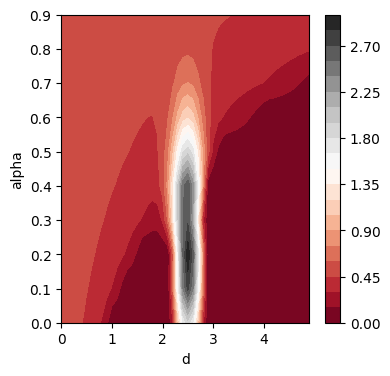

epoch 350 / 500 : loss = 0.19680988788604736


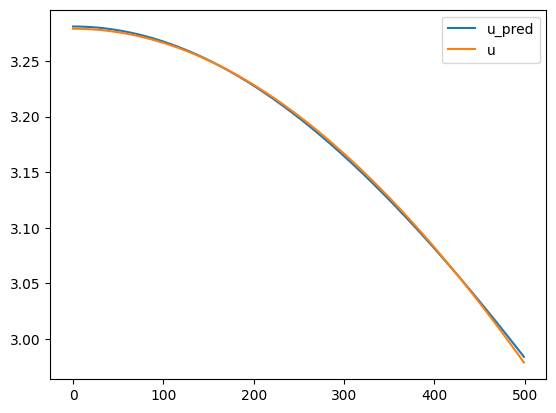

epoch 351 / 500 : loss = 0.1967817097902298
epoch 352 / 500 : loss = 0.19675381481647491
epoch 353 / 500 : loss = 0.19672581553459167
epoch 354 / 500 : loss = 0.19669756293296814


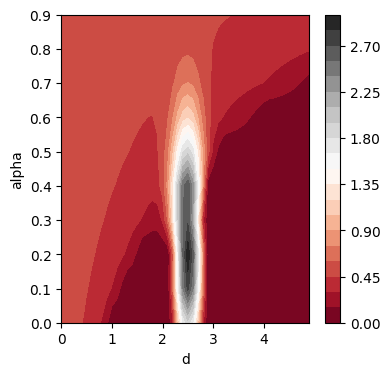

epoch 355 / 500 : loss = 0.19666962325572968


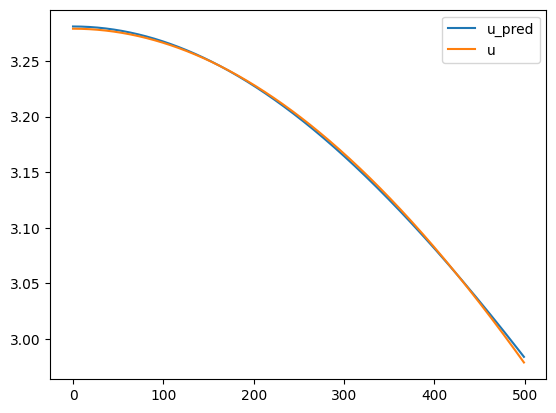

epoch 356 / 500 : loss = 0.19664129614830017
epoch 357 / 500 : loss = 0.19661322236061096
epoch 358 / 500 : loss = 0.1965850293636322
epoch 359 / 500 : loss = 0.1965564340353012


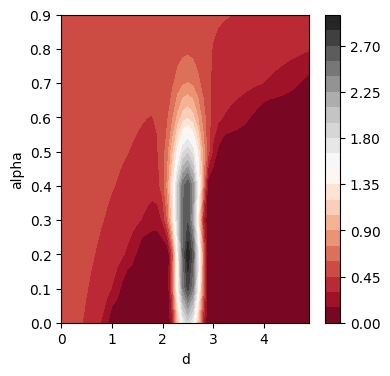

epoch 360 / 500 : loss = 0.1965286284685135


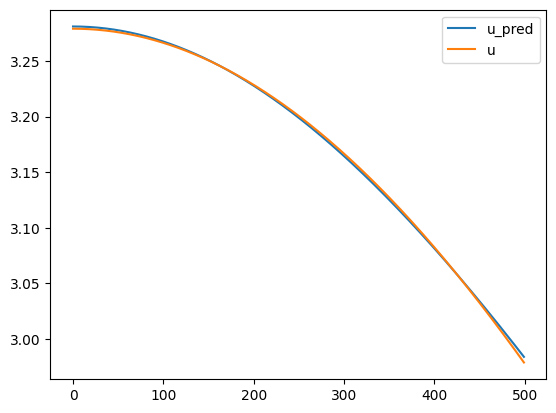

epoch 361 / 500 : loss = 0.19650018215179443
epoch 362 / 500 : loss = 0.19647212326526642
epoch 363 / 500 : loss = 0.19644370675086975
epoch 364 / 500 : loss = 0.19641520082950592


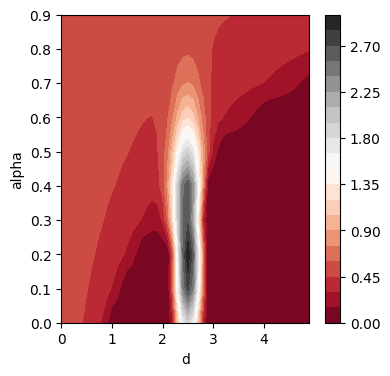

epoch 365 / 500 : loss = 0.19638656079769135


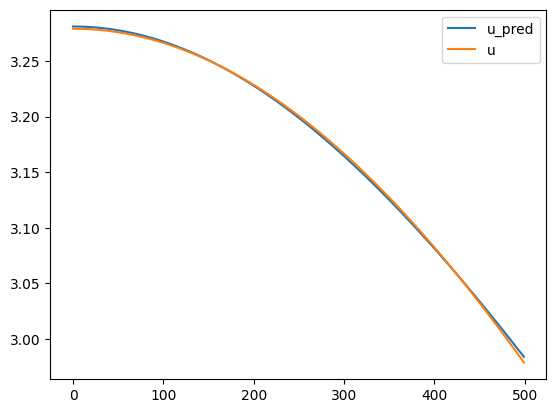

epoch 366 / 500 : loss = 0.19635826349258423
epoch 367 / 500 : loss = 0.1963297426700592
epoch 368 / 500 : loss = 0.19630147516727448
epoch 369 / 500 : loss = 0.19627302885055542


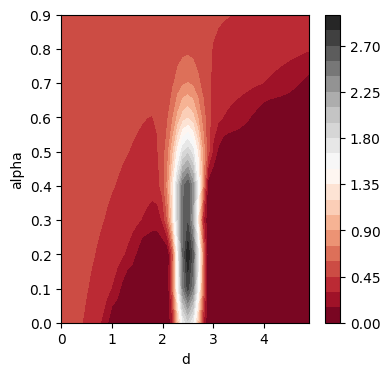

epoch 370 / 500 : loss = 0.1962442547082901


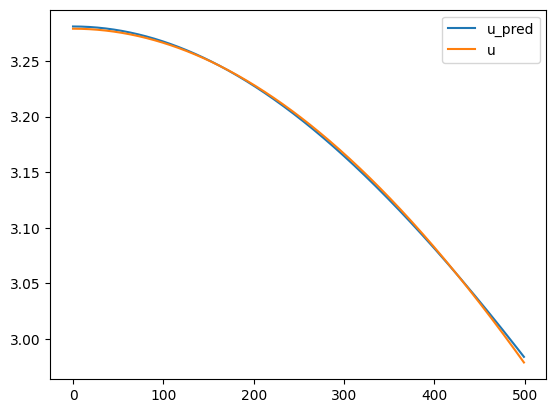

epoch 371 / 500 : loss = 0.19621577858924866
epoch 372 / 500 : loss = 0.19618740677833557
epoch 373 / 500 : loss = 0.19615861773490906
epoch 374 / 500 : loss = 0.19612981379032135


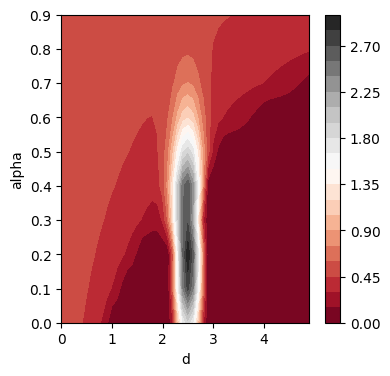

epoch 375 / 500 : loss = 0.1961013525724411


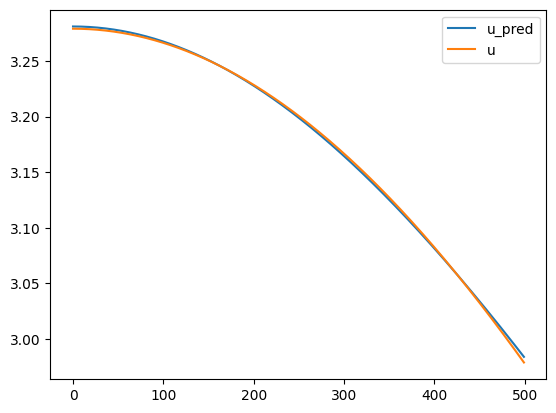

epoch 376 / 500 : loss = 0.19607235491275787
epoch 377 / 500 : loss = 0.1960434913635254
epoch 378 / 500 : loss = 0.19601504504680634
epoch 379 / 500 : loss = 0.1959863156080246


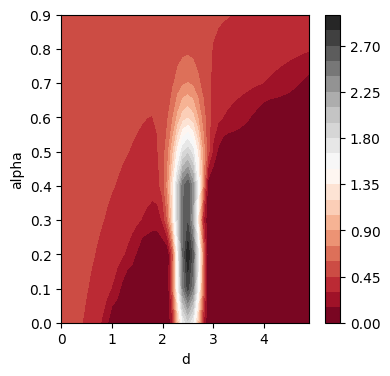

epoch 380 / 500 : loss = 0.19595755636692047


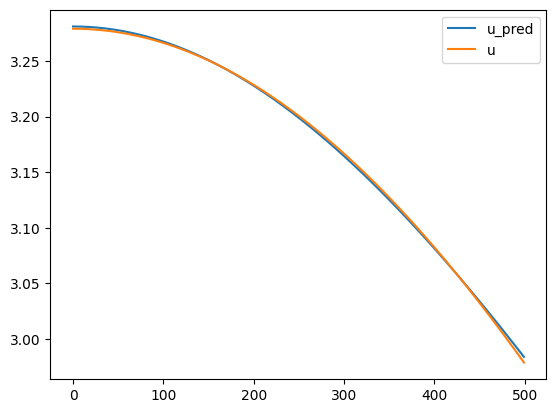

epoch 381 / 500 : loss = 0.19592870771884918
epoch 382 / 500 : loss = 0.19589975476264954
epoch 383 / 500 : loss = 0.19587093591690063
epoch 384 / 500 : loss = 0.19584204256534576


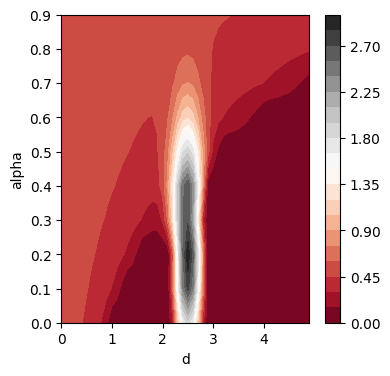

epoch 385 / 500 : loss = 0.19581297039985657


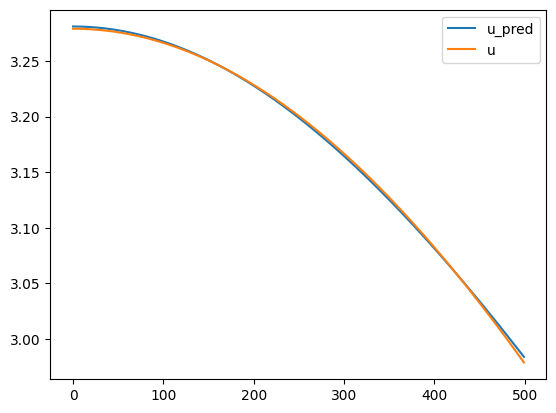

epoch 386 / 500 : loss = 0.19578418135643005
epoch 387 / 500 : loss = 0.1957552433013916
epoch 388 / 500 : loss = 0.19572578370571136
epoch 389 / 500 : loss = 0.19569706916809082


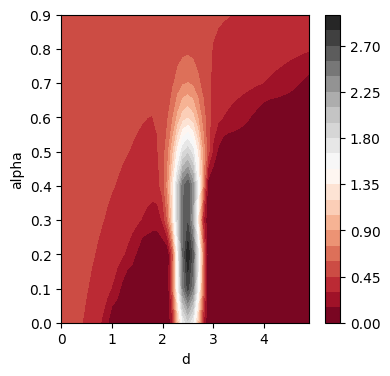

epoch 390 / 500 : loss = 0.19566792249679565


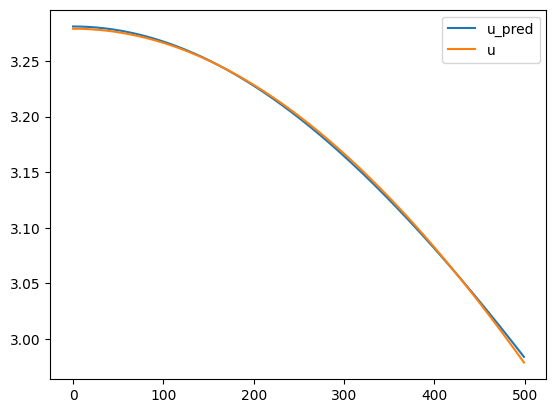

epoch 391 / 500 : loss = 0.19563890993595123
epoch 392 / 500 : loss = 0.1956101804971695
epoch 393 / 500 : loss = 0.19558054208755493
epoch 394 / 500 : loss = 0.19555161893367767


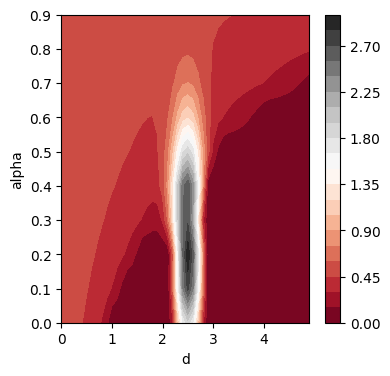

epoch 395 / 500 : loss = 0.19552230834960938


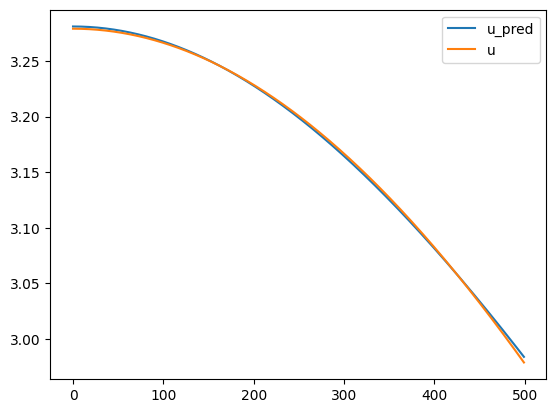

epoch 396 / 500 : loss = 0.1954934298992157
epoch 397 / 500 : loss = 0.19546400010585785
epoch 398 / 500 : loss = 0.19543440639972687
epoch 399 / 500 : loss = 0.19540534913539886


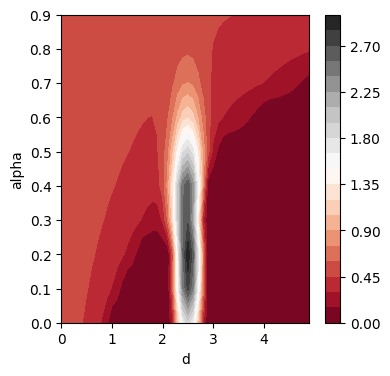

epoch 400 / 500 : loss = 0.19537600874900818


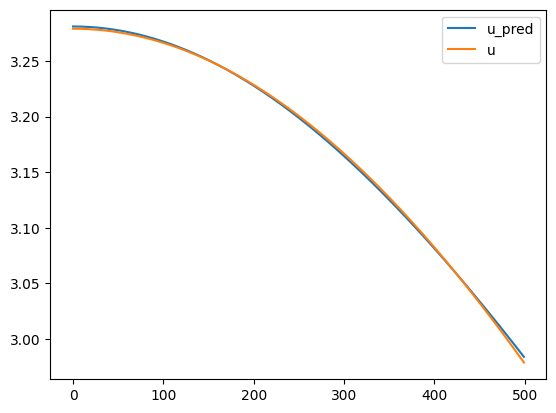

epoch 401 / 500 : loss = 0.1953466683626175
epoch 402 / 500 : loss = 0.19531738758087158
epoch 403 / 500 : loss = 0.1952877640724182
epoch 404 / 500 : loss = 0.19525863230228424


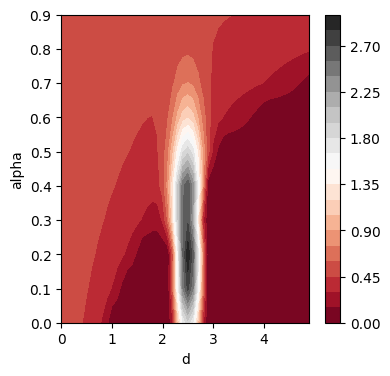

epoch 405 / 500 : loss = 0.1952289491891861


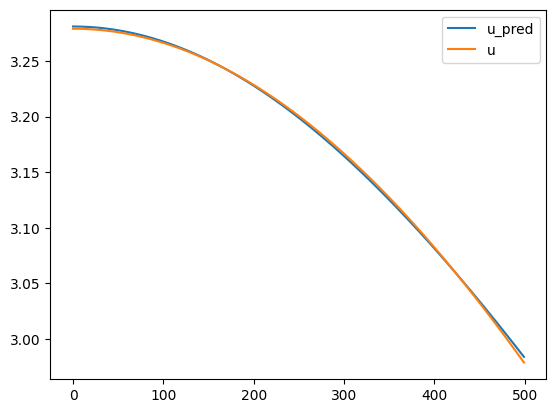

epoch 406 / 500 : loss = 0.19519959390163422
epoch 407 / 500 : loss = 0.19517023861408234
epoch 408 / 500 : loss = 0.19514046609401703
epoch 409 / 500 : loss = 0.1951109915971756


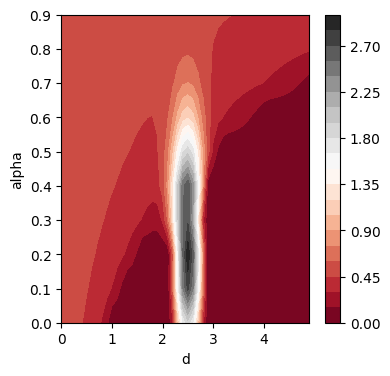

epoch 410 / 500 : loss = 0.1950816512107849


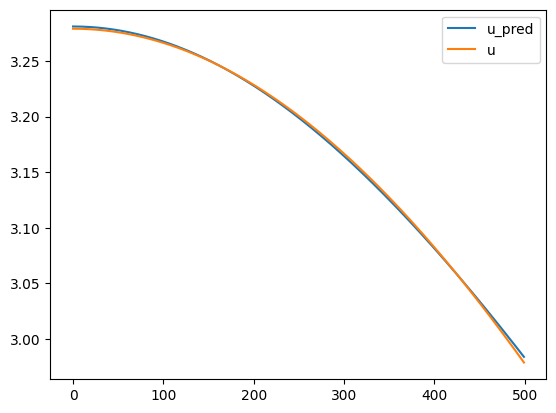

epoch 411 / 500 : loss = 0.19505205750465393
epoch 412 / 500 : loss = 0.19502249360084534
epoch 413 / 500 : loss = 0.19499273598194122
epoch 414 / 500 : loss = 0.19496317207813263


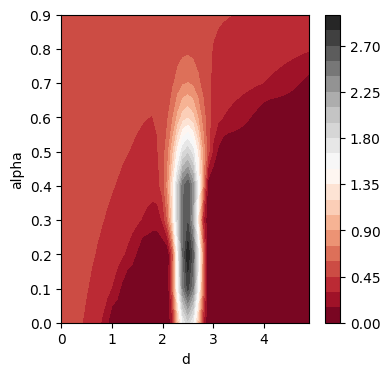

epoch 415 / 500 : loss = 0.19493356347084045


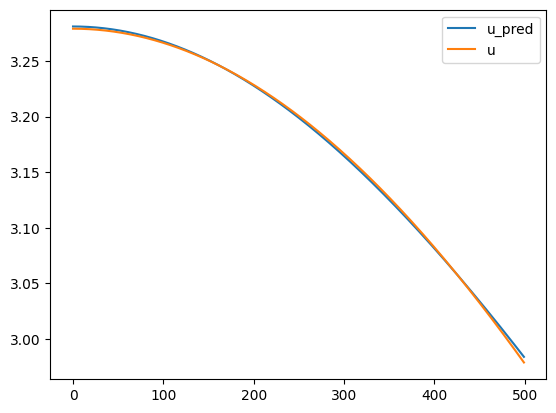

epoch 416 / 500 : loss = 0.1949041485786438
epoch 417 / 500 : loss = 0.19487452507019043
epoch 418 / 500 : loss = 0.19484500586986542
epoch 419 / 500 : loss = 0.19481509923934937


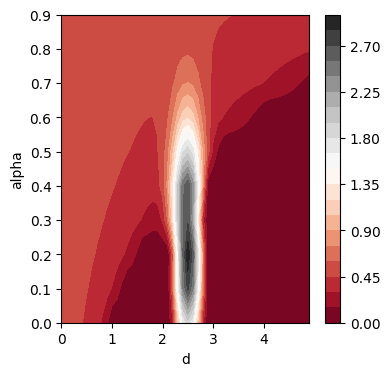

epoch 420 / 500 : loss = 0.19478556513786316


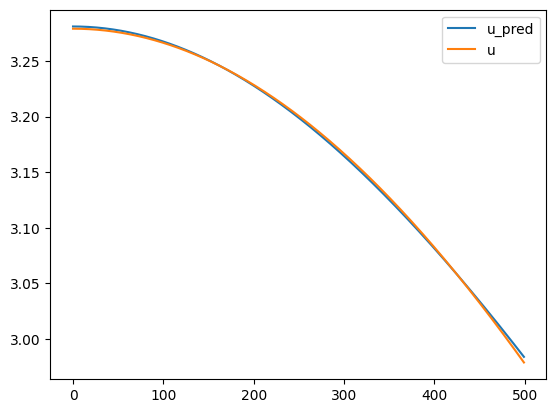

epoch 421 / 500 : loss = 0.1947554349899292
epoch 422 / 500 : loss = 0.1947261542081833
epoch 423 / 500 : loss = 0.1946963369846344
epoch 424 / 500 : loss = 0.19466620683670044


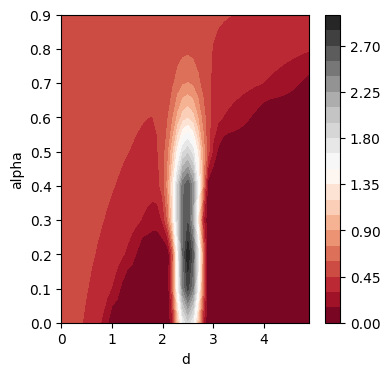

epoch 425 / 500 : loss = 0.19463664293289185


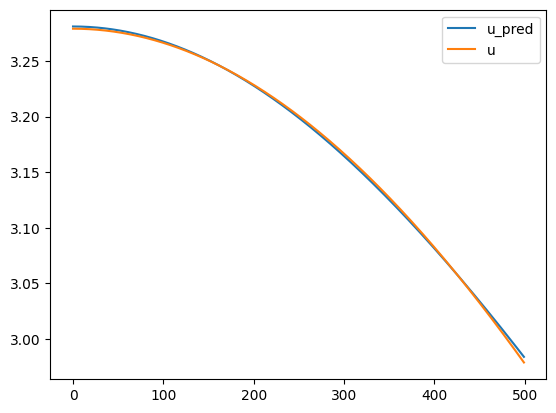

epoch 426 / 500 : loss = 0.19460678100585938
epoch 427 / 500 : loss = 0.1945769339799881
epoch 428 / 500 : loss = 0.1945468783378601
epoch 429 / 500 : loss = 0.19451728463172913


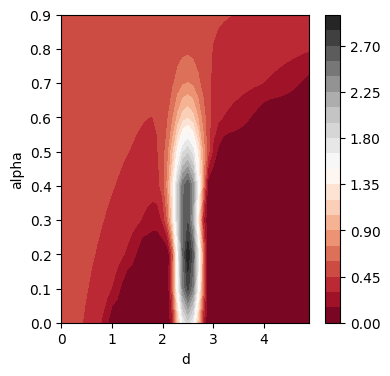

epoch 430 / 500 : loss = 0.19448690116405487


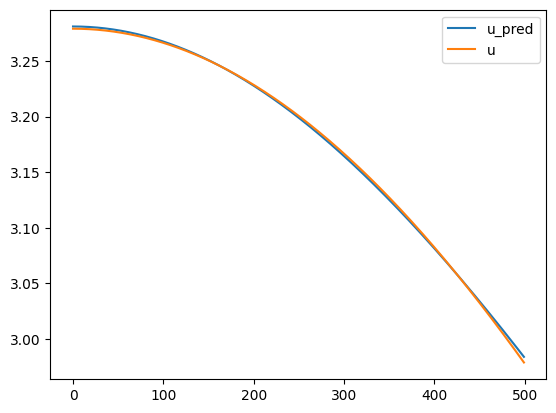

epoch 431 / 500 : loss = 0.19445733726024628
epoch 432 / 500 : loss = 0.1944272667169571
epoch 433 / 500 : loss = 0.19439730048179626
epoch 434 / 500 : loss = 0.19436755776405334


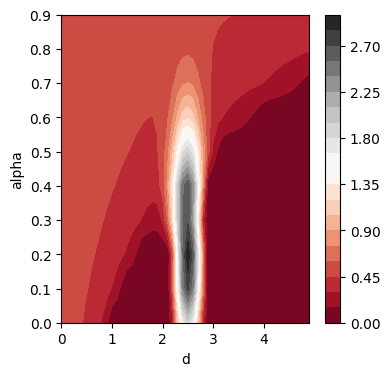

epoch 435 / 500 : loss = 0.19433748722076416


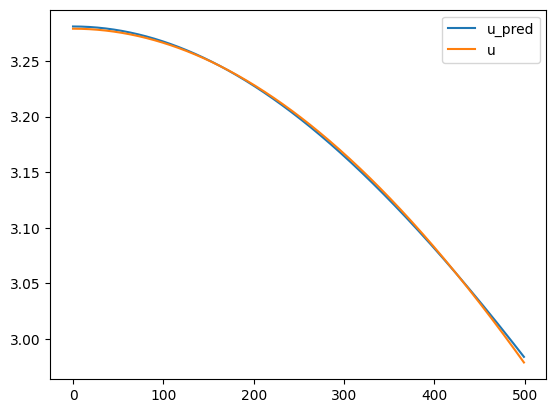

epoch 436 / 500 : loss = 0.19430741667747498
epoch 437 / 500 : loss = 0.19427740573883057
epoch 438 / 500 : loss = 0.19424743950366974
epoch 439 / 500 : loss = 0.19421765208244324


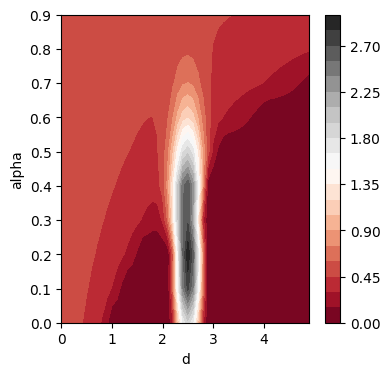

epoch 440 / 500 : loss = 0.19418756663799286


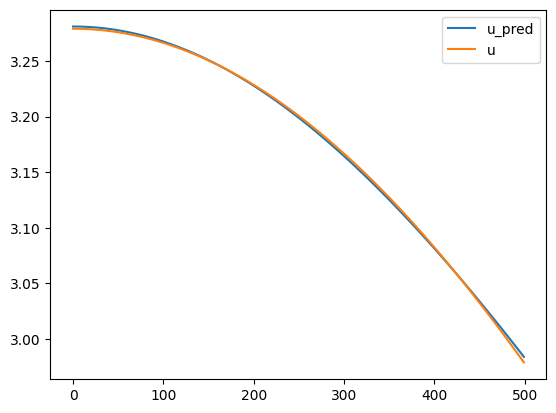

epoch 441 / 500 : loss = 0.19415715336799622
epoch 442 / 500 : loss = 0.19412699341773987
epoch 443 / 500 : loss = 0.19409742951393127
epoch 444 / 500 : loss = 0.19406701624393463


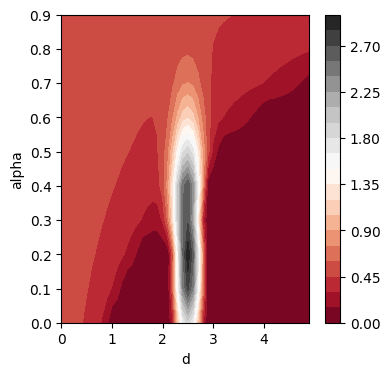

epoch 445 / 500 : loss = 0.1940368413925171


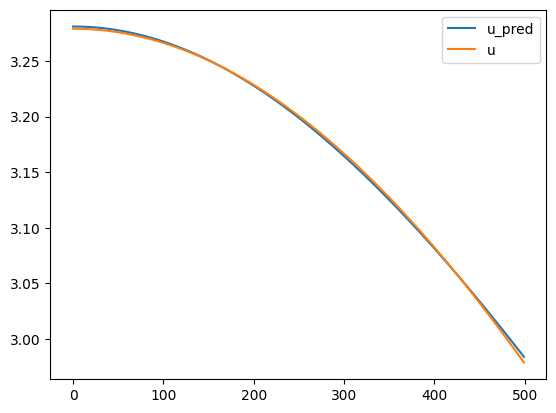

epoch 446 / 500 : loss = 0.19400674104690552
epoch 447 / 500 : loss = 0.19397619366645813
epoch 448 / 500 : loss = 0.19394636154174805
epoch 449 / 500 : loss = 0.19391591846942902


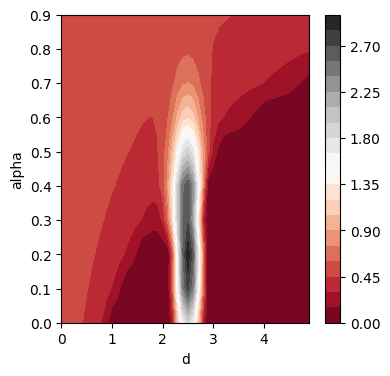

epoch 450 / 500 : loss = 0.19388550519943237


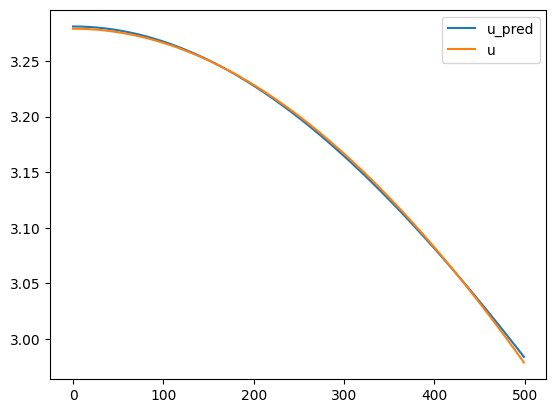

epoch 451 / 500 : loss = 0.19385547935962677
epoch 452 / 500 : loss = 0.1938249170780182
epoch 453 / 500 : loss = 0.19379448890686035
epoch 454 / 500 : loss = 0.19376440346240997


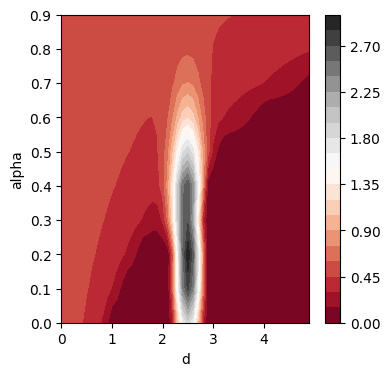

epoch 455 / 500 : loss = 0.19373364746570587


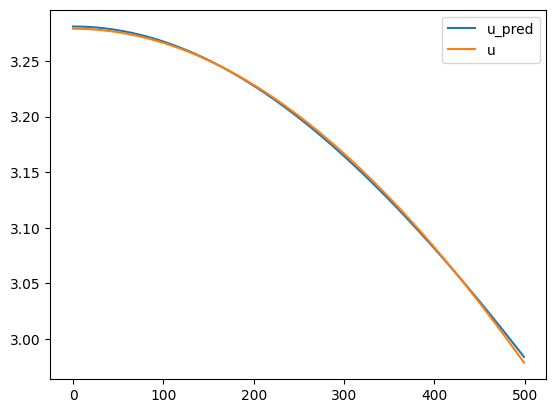

epoch 456 / 500 : loss = 0.19370368123054504
epoch 457 / 500 : loss = 0.19367310404777527
epoch 458 / 500 : loss = 0.1936424821615219
epoch 459 / 500 : loss = 0.19361183047294617


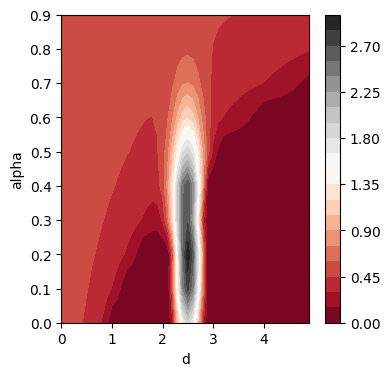

epoch 460 / 500 : loss = 0.19358143210411072


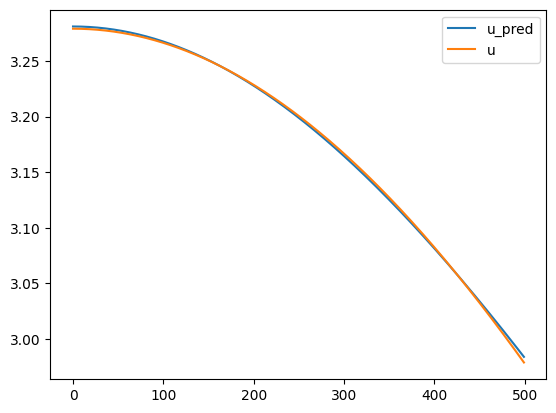

epoch 461 / 500 : loss = 0.19355085492134094
epoch 462 / 500 : loss = 0.19352048635482788
epoch 463 / 500 : loss = 0.19348984956741333
epoch 464 / 500 : loss = 0.19345895946025848


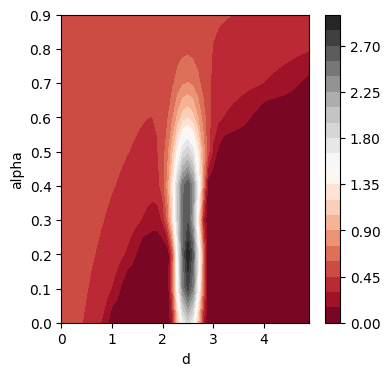

epoch 465 / 500 : loss = 0.19342860579490662


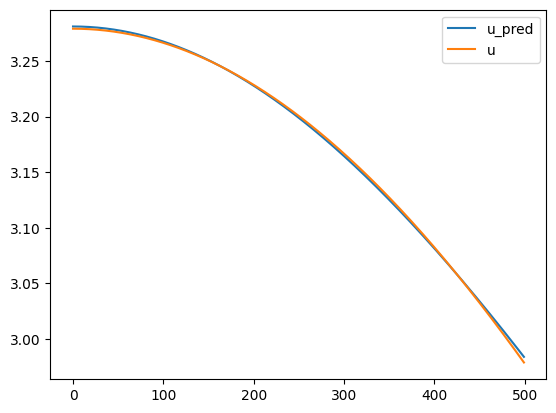

epoch 466 / 500 : loss = 0.19339784979820251
epoch 467 / 500 : loss = 0.19336727261543274
epoch 468 / 500 : loss = 0.19333632290363312
epoch 469 / 500 : loss = 0.19330528378486633


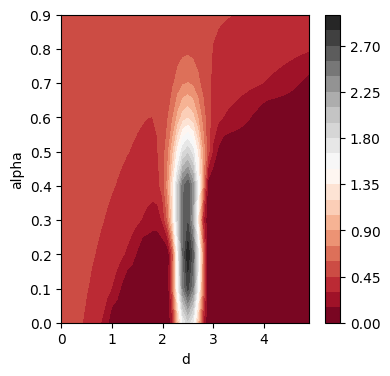

epoch 470 / 500 : loss = 0.19327494502067566


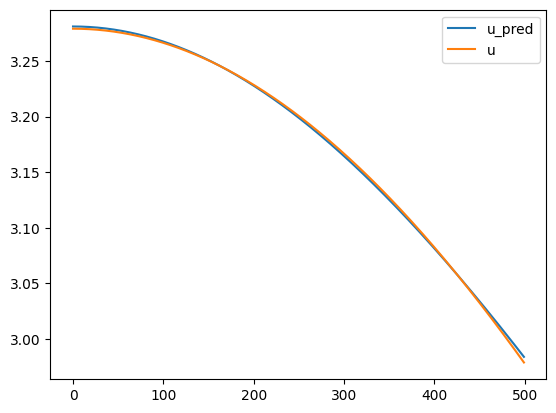

epoch 471 / 500 : loss = 0.193244069814682
epoch 472 / 500 : loss = 0.1932135820388794
epoch 473 / 500 : loss = 0.19318246841430664
epoch 474 / 500 : loss = 0.19315241277217865


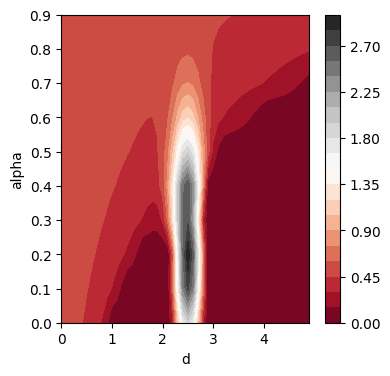

epoch 475 / 500 : loss = 0.1931222528219223


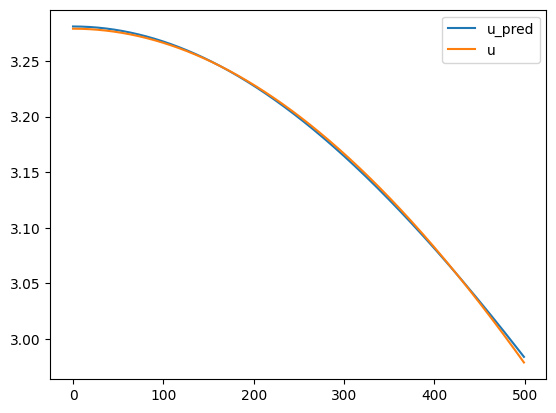

epoch 476 / 500 : loss = 0.1930924504995346
epoch 477 / 500 : loss = 0.1930624097585678
epoch 478 / 500 : loss = 0.1930326223373413
epoch 479 / 500 : loss = 0.1930026262998581


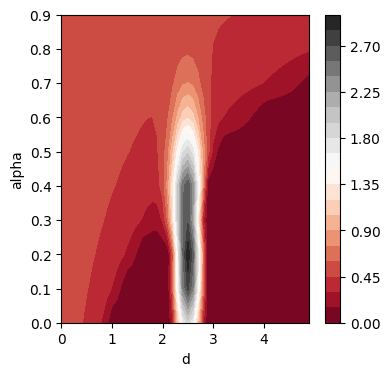

epoch 480 / 500 : loss = 0.19297273457050323


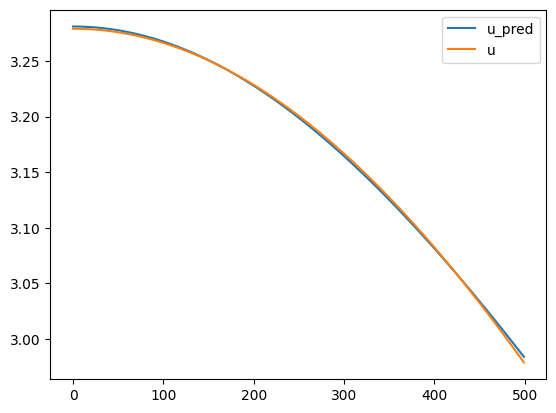

epoch 481 / 500 : loss = 0.19294269382953644
epoch 482 / 500 : loss = 0.19291278719902039
epoch 483 / 500 : loss = 0.19288279116153717
epoch 484 / 500 : loss = 0.19285288453102112


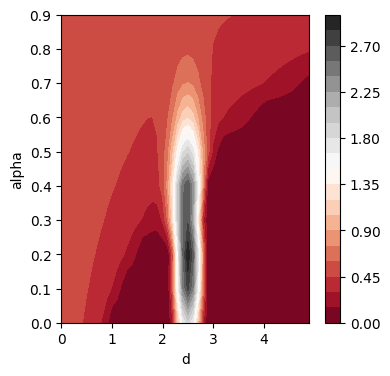

epoch 485 / 500 : loss = 0.19282276928424835


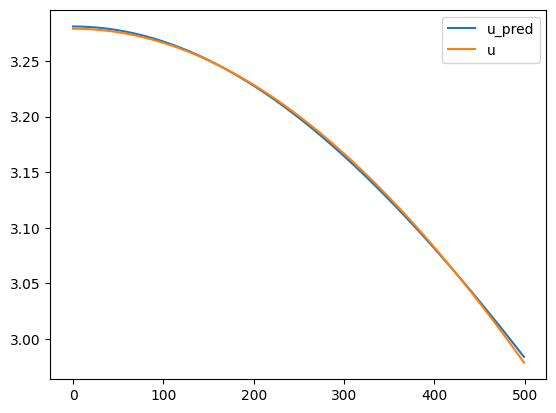

epoch 486 / 500 : loss = 0.19279280304908752
epoch 487 / 500 : loss = 0.1927623599767685
epoch 488 / 500 : loss = 0.19273243844509125
epoch 489 / 500 : loss = 0.19270233809947968


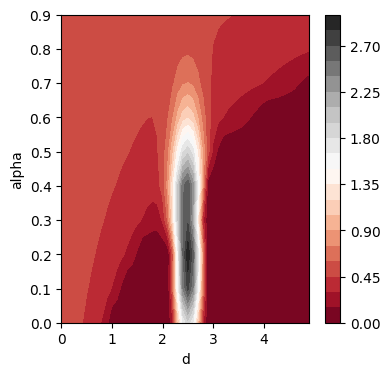

epoch 490 / 500 : loss = 0.19267213344573975


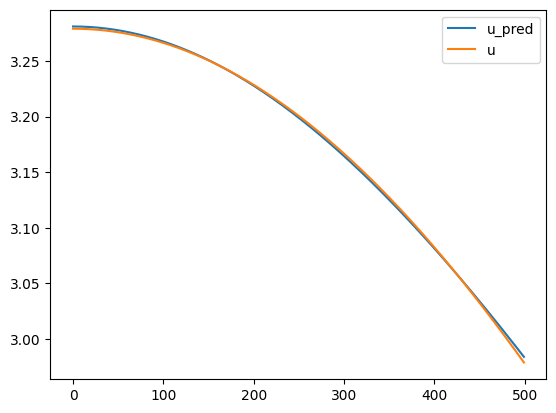

epoch 491 / 500 : loss = 0.19264228641986847
epoch 492 / 500 : loss = 0.19261157512664795
epoch 493 / 500 : loss = 0.19258151948451996
epoch 494 / 500 : loss = 0.19255158305168152


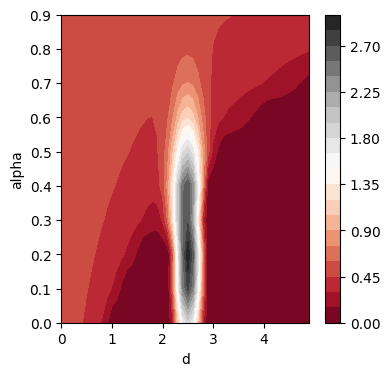

epoch 495 / 500 : loss = 0.19252127408981323


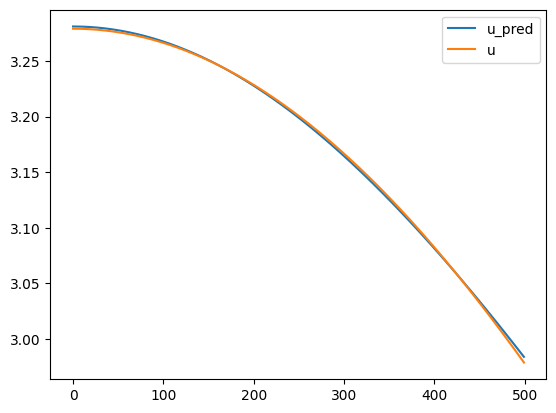

epoch 496 / 500 : loss = 0.19249066710472107
epoch 497 / 500 : loss = 0.1924603432416916
epoch 498 / 500 : loss = 0.19242985546588898
epoch 499 / 500 : loss = 0.19239963591098785


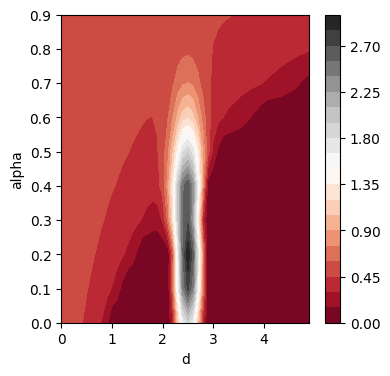

epoch 500 / 500 : loss = 0.1923692375421524


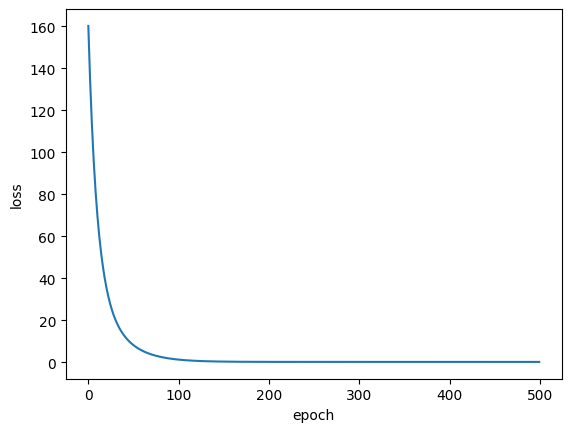

In [121]:
# train the model
P_alpha_d = train(P_alpha_d, u, Z, alpha_vals, d_vals, num_epochs=500, lr=1e-2)

In [122]:
P_alpha_d_cpu = P_alpha_d.cpu().detach().numpy()
# normalize P_alpha_d_cpu
# P_alpha_d_cpu = P_alpha_d_cpu / (P_alpha_d_cpu.sum(axis=(1,2), keepdims=True))
print(f"shape of P_alpha_d_cpu : {P_alpha_d_cpu.shape}")
# save P_alpha_d_cpu
np.save("P_alpha_d_cpu.npy", P_alpha_d_cpu)

shape of P_alpha_d_cpu : (100, 10, 50)


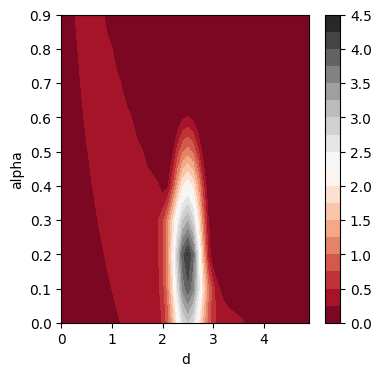

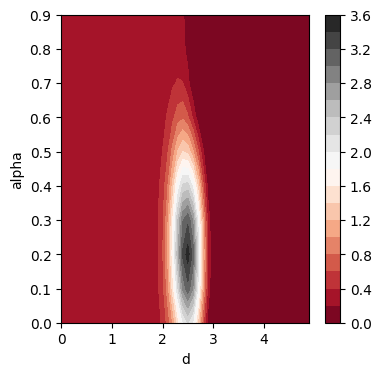

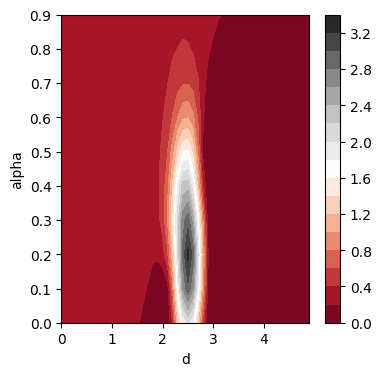

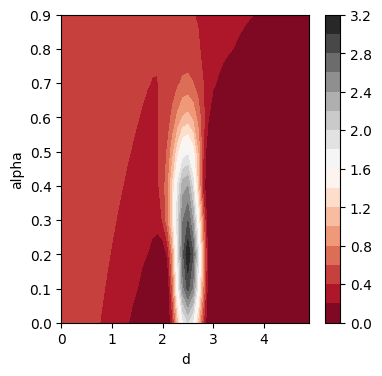

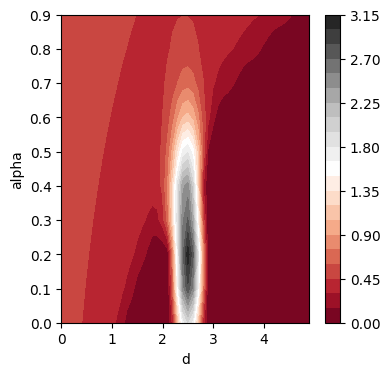

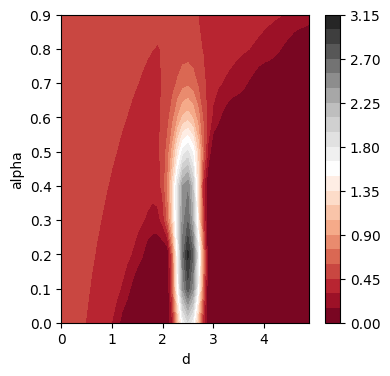

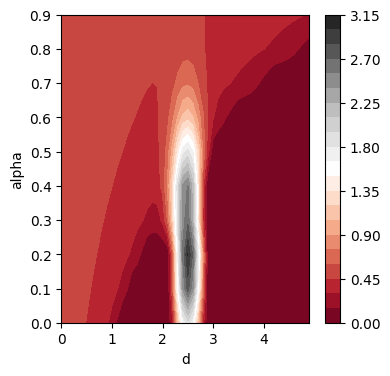

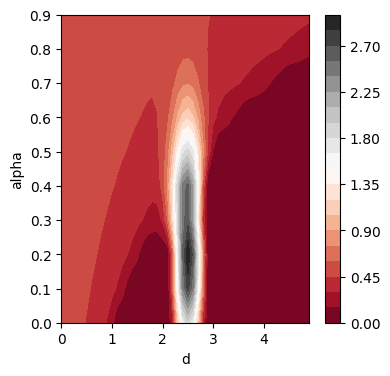

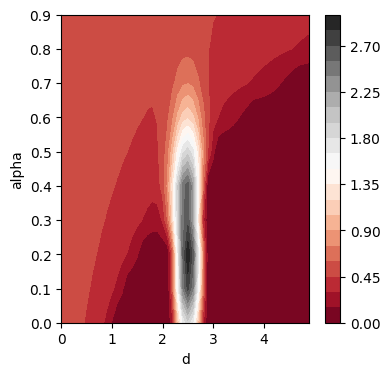

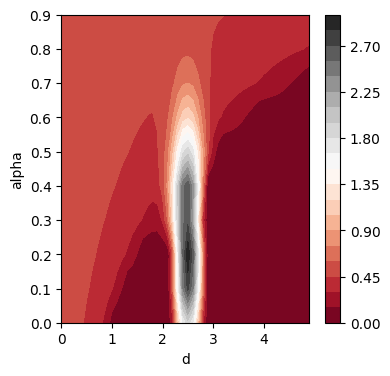

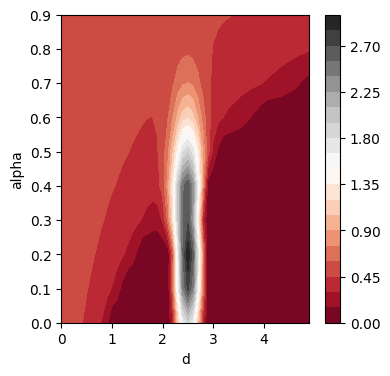

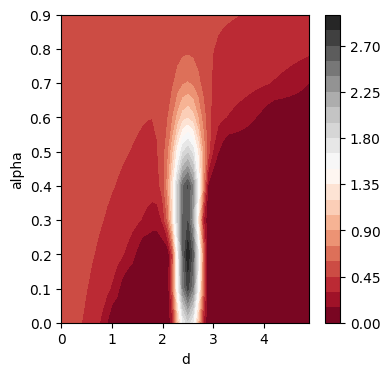

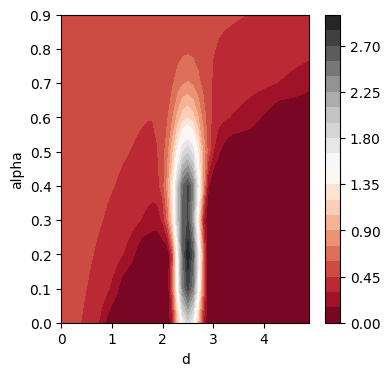

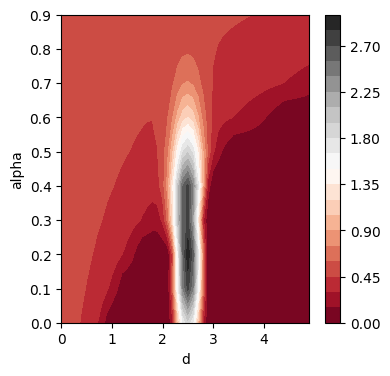

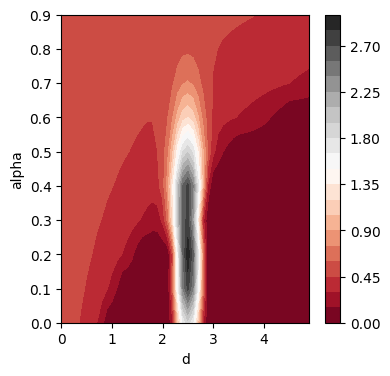

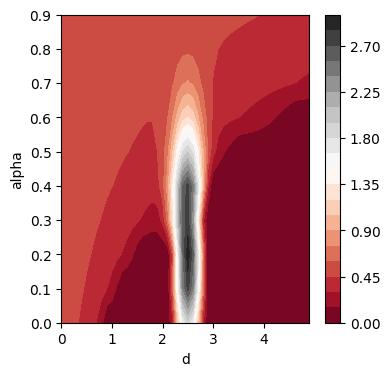

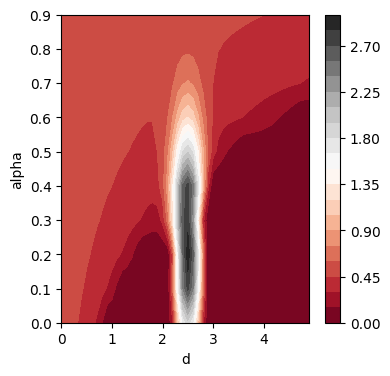

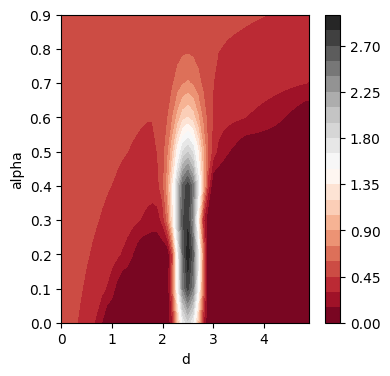

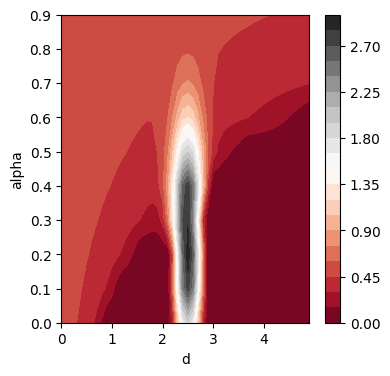

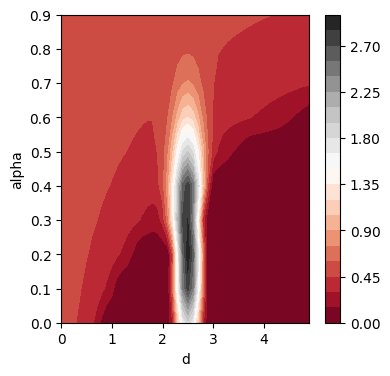

In [123]:
for i in range(0, num_frames, 5):
    # copy P_alpha_d to cpu
    contour_plt(P_alpha_d_cpu, i)

In [124]:
def give_u_pred_np_and_plot(P_alpha_d, Z, alpha_vals, d_vals, r_vals):
    """
    Given P_alpha_d, Z, alpha_vals, d_vals, return u_pred
    """
    # initialize u_pred
    u_pred = np.zeros((num_frames, len(r_vals)))

    # convert P_alpha_d to numpy array
    P_alpha_d = P_alpha_d.cpu().detach().numpy()
    Z = Z.cpu().detach().numpy()
    alpha_vals = alpha_vals.cpu().detach().numpy()
    d_vals = d_vals.cpu().detach().numpy()

    for i in range(u_pred.shape[0]):
        for j in range(u_pred.shape[1]):
            integrand = np.trapz(P_alpha_d[i] * Z[:, :, i, j], d_vals, axis=1)
            u_pred[i, j] = np.trapz(integrand, alpha_vals)

    # normalize u_pred
    u_pred = u_pred / (u_pred.sum(axis=1, keepdims=True) + 1e-6)
    # u_pred = u_pred / (u_pred.sum(axis=1, keepdims=True))

    # s_vals = np.linspace(0.0, 2*np.pi, 101)
    s_vals = np.linspace(0.1, 20.1, 101)
    # s_vals[0] = 1e-10
    s_vals = s_vals[:-1]

    # get the range of k values
    # convert r_vals to numpy array
    r_vals = r_vals.cpu().detach().numpy()
    k_vals = fft.fftfreq(r_vals.shape[0], d=r_vals[1]-r_vals[0])
    k_vals = fft.fftshift(k_vals)
    # k_vals = 2 * np.pi * k_vals
    # print(k_vals)
    print(f"shape of k_vals : {k_vals.shape}")

    # visualize u_pred
    plt.figure(figsize=(10, 8))
    plt.title("u_pred(s, k) for some s values")
    plt.xlabel("k")
    plt.ylabel("u_pred(s, k)")
    plt.grid()
    for i in range(0, s_vals.shape[0], 10):
        if i == 0:
            continue
        plt.plot(k_vals, u_pred[i, :], label=f"s = {s_vals[i]:.2f}")

    plt.legend()
    plt.show()

shape of k_vals : (500,)


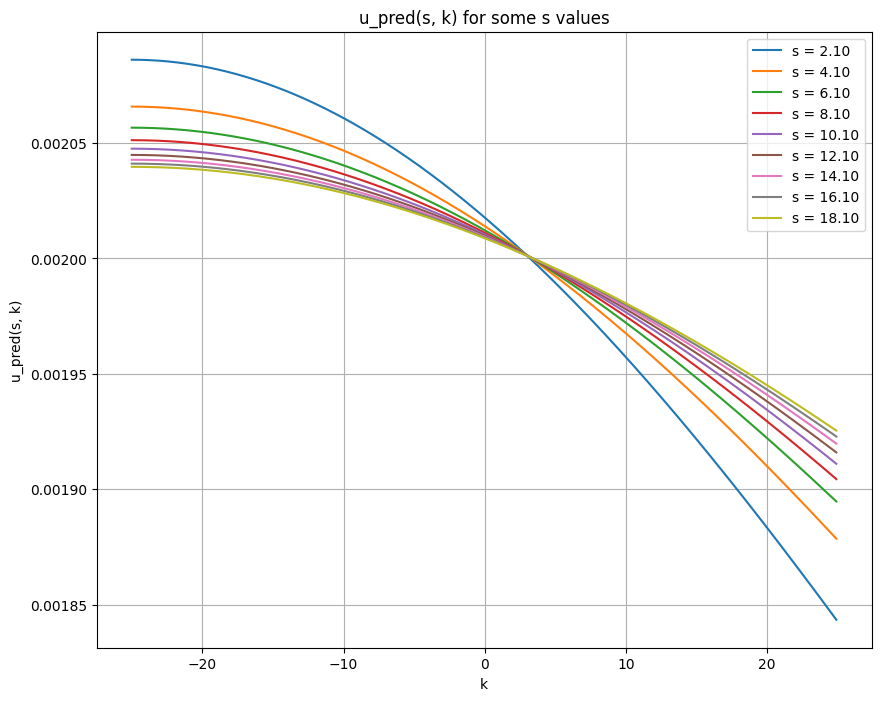

In [125]:
# reproduce u_pred
give_u_pred_np_and_plot(P_alpha_d, Z, alpha_vals, d_vals, r_vals)
